In [95]:
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from peewee import *

Настраиваем все для работы с БД

In [6]:
db = PostgresqlDatabase('openedu', host='localhost', port=5432, user='postgres', password='7003')

In [2]:
class BaseModel(Model):
    class Meta:
        database = db


class User(BaseModel):
    user_id = IntegerField(column_name='id', primary_key=True)
    username = TextField(column_name='username', null=False)

    class Meta:
        db_table = 'users'


class Course(BaseModel):
    course_id = AutoField(column_name='id')
    course_name = TextField(column_name='course_name', unique=True, null=False)

    class Meta:
        db_table = 'courses'


class VideoInteractionEvent(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)
    type_event = TextField(column_name='type_event', null=False, constraints=[Check(
        'type_event = \'pause_video\' or type_event = \'play_video\' or type_event = \'seek_video\' or type_event = '
        '\'speed_change_video\'')])
    video_id = TextField(column_name='video_id', null=False)
    current_time_video = DoubleField(column_name='current_time_video', null=True)
    new_time = DoubleField(column_name='new_time', null=True)
    old_time = DoubleField(column_name='old_time', null=True)
    new_speed = DoubleField(column_name='new_speed', null=True)
    old_speed = DoubleField(column_name='old_speed', null=True)

    class Meta:
        db_table = 'video_interaction_events'


class BookEvent(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)
    chapter = TextField(column_name='chapter', null=False)
    type_event = TextField(column_name='type_event', null=False, constraints=[
        Check('type_event = \'gotopage\' or type_event = \'prevpage\' or type_event = \'nextpage\'')])
    new_page = IntegerField(column_name='new_page', null=False)
    old_page = IntegerField(column_name='old_page', null=True)

    class Meta:
        db_table = 'book_interaction_events'


class NavigationEvent(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)
    type_event = TextField(column_name='type_event', null=False, constraints=[
        Check('type_event = \'seq_goto\' or type_event = \'seq_next\' or type_event = \'seq_prev\'')])
    seq_id = TextField(column_name='seq_id', null=False)
    new_page = IntegerField(column_name='new_page', null=False)
    old_page = IntegerField(column_name='old_page', null=False)

    class Meta:
        db_table = 'navigation_events'


class ProblemInteractionEvent(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)
    problem_id = TextField(column_name='problem_id', null=False)
    attempts = IntegerField(column_name='attempts', null=False)
    grade = IntegerField(column_name='grade', null=False)
    max_grade = IntegerField(column_name='max_grade', null=False)
    success = TextField(column_name='success', null=False,
                        constraints=[Check('success = \'correct\' or success = \'incorrect\'')])

    class Meta:
        db_table = 'problem_interaction_events'


class EnrollmentEvent(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)

    class Meta:
        db_table = 'enrollment_events'


class CertificateEvents(BaseModel):
    id = AutoField(column_name='id')
    user_id = ForeignKeyField(User, field='user_id')
    course_id = ForeignKeyField(Course, field='course_id')
    time_event = DateTimeField(column_name='time_event', null=False)

    class Meta:
        db_table = 'certificate_events'


In [ ]:
@db.atomic()
def create_user(data):
    try:
        return User.create(user_id=data['context']['user_id'], username=data['username'])
    except IntegrityError:
        pass


@db.atomic()
def create_course(data):
    try:
        return Course.create(course_name=data['context']['course_id'])
    except IntegrityError:
        pass


@db.atomic()
def create_video_play_pause(data):
    data_event = json.loads(data['event'])
    return VideoInteractionEvent.create(user_id=data['context']['user_id'],
                                               course_id=Course.select().where(
                                                   Course.course_name == data['context'][
                                                       'course_id']).get().course_id,
                                               type_event=data['event_type'], time_event=data['time'],
                                               video_id=data_event['id'],
                                               current_time_video=data_event['currentTime'])


@db.atomic()
def create_video_seek(data):
    data_event = json.loads(data['event'])
    return VideoInteractionEvent.create(user_id=data['context']['user_id'],
                                               course_id=Course.select().where(
                                                   Course.course_name == data['context'][
                                                       'course_id']).get().course_id,
                                               type_event=data['event_type'], time_event=data['time'],
                                               video_id=data_event['id'], new_time=data_event['new_time'],
                                               old_time=data_event['old_time'])


@db.atomic()
def create_video_speed(data):
    data_event = json.loads(data['event'])
    return VideoInteractionEvent.create(user_id=data['context']['user_id'],
                                               course_id=Course.select().where(
                                                   Course.course_name == data['context'][
                                                       'course_id']).get().course_id,
                                               type_event=data['event_type'], time_event=data['time'],
                                               video_id=data_event['id'],
                                               current_time_video=data_event['current_time'],
                                               new_speed=data_event['new_speed'],
                                               old_speed=data_event['old_speed'])


@db.atomic()
def create_book(data):
    data_event = json.loads(data['event'])
    old_page = None
    if data_event['type'] == 'gotopage':
        old_page = data_event['old']
    return BookEvent.create(user_id=data['context']['user_id'],
                                   course_id=Course.select().where(
                                       Course.course_name == data['context'][
                                           'course_id']).get().course_id,
                                   type_event=data_event['type'], time_event=data['time'],
                                   chapter=data_event['chapter'],
                                   new_page=data_event['new'], old_page=old_page)


@db.atomic()
def create_navigation(data):
    data_event = json.loads(data['event'])
    return NavigationEvent.create(user_id=data['context']['user_id'],
                                         course_id=Course.select().where(
                                             Course.course_name == data['context'][
                                                 'course_id']).get().course_id,
                                         type_event=data['event_type'], time_event=data['time'],
                                         seq_id=data_event['id'],
                                         new_page=data_event['new'], old_page=data_event['old'])


@db.atomic()
def create_problem(data):
    return ProblemInteractionEvent.create(user_id=data['context']['user_id'],
                                                 course_id=Course.select().where(
                                                     Course.course_name == data['context'][
                                                         'course_id']).get().course_id,
                                                 time_event=data['time'], problem_id=data['event']['problem_id'],
                                                 attempts=data['event']['attempts'], grade=data['event']['grade'],
                                                 max_grade=data['event']['max_grade'], success=data['event']['success'])


@db.atomic()
def create_certificate(data):
    return CertificateEvents.create(user_id=data['context']['user_id'],
                                           course_id=Course.select().where(
                                               Course.course_name == data['context'][
                                                   'course_id']).get().course_id, time_event=data['time'])


@db.atomic()
def create_enrollment(data):
    return EnrollmentEvent.create(user_id=data['context']['user_id'],
                                         course_id=Course.select().where(
                                             Course.course_name == data['context'][
                                                 'course_id']).get().course_id, time_event=data['time'])


Функция для загрузки информации из логов в БД

In [3]:
def load_data(path):
    i = 1
    os.chdir(path)
    all_log_files = glob.glob('*.log')
    for entry in all_log_files:
        print(i)
        i += 1
        with open(entry, 'rt') as file:
            for line in file:
                data = json.loads(line)
                try:
                    user_id = data['context']['user_id']
                except KeyError:
                    continue
                if user_id is not None:
                    match data['event_type']:
                        case "play_video" | "pause_video":
                            create_user(data)
                            create_course(data)
                            create_video_play_pause(data)
                        case "seek_video":
                            create_user(data)
                            create_course(data)
                            create_video_seek(data)
                        case "speed_change_video":
                            create_user(data)
                            create_course(data)
                            create_video_speed(data)
                        case "book":
                            create_user(data)
                            create_course(data)
                            create_book(data)
                        case "seq_goto" | "seq_next" | "seq_prev":
                            create_user(data)
                            create_course(data)
                            create_navigation(data)
                        case "problem_check":
                            if data['event_source'] == 'server':
                                create_user(data)
                                create_course(data)
                                create_problem(data)
                            else:
                                continue
                        case "edx.course.enrollment.activated":
                            create_user(data)
                            create_course(data)
                            create_enrollment(data)
                        case "edx.certificate.created":
                            create_user(data)
                            create_course(data)
                            create_certificate(data)


Вспомогательные функции для работы с БД

In [4]:
def create_tables():
    User.create_table()
    Course.create_table()
    VideoInteractionEvent.create_table()
    BookEvent.create_table()
    NavigationEvent.create_table()
    ProblemInteractionEvent.create_table()
    EnrollmentEvent.create_table()
    CertificateEvents.create_table()


def drop_tables():
    m = (User, Course, VideoInteractionEvent, BookEvent, NavigationEvent,
         ProblemInteractionEvent, EnrollmentEvent, CertificateEvents)
    db.drop_tables(m)


def get_data(course_id):
    query_problem = ProblemInteractionEvent.select().where(ProblemInteractionEvent.course_id == course_id)
    query_book = BookEvent.select().where(BookEvent.course_id == course_id)
    query_video = VideoInteractionEvent.select().where((VideoInteractionEvent.course_id == course_id) &
                                                              (VideoInteractionEvent.type_event == 'play_video'))
    df_problem = pd.DataFrame(query_problem.dicts())
    df_book = pd.DataFrame(query_book.dicts())
    df_video = pd.DataFrame(query_video.dicts())
    return df_problem, df_book, df_video


Функция, возвращающая пользователей, которые не будут участвовать в дальнейшем анализе курса
(пользователи подозреваемые в списывании и пользователи с нулевым прогрессом)

In [18]:
def users_unappropr(df):
    df_user_percent = users_percent_task(df)
    users_cheated = df_user_percent.loc[
        ((df_user_percent.percent_suc_attemp == 100) & (df_user_percent.percent_comp_task >= 75)), 'user_id']
    users_zero_prog = df_user_percent.loc[(df_user_percent.percent_comp_task == 0), 'user_id']
    if not users_cheated.empty:
        print('Студенты, подозреваемые в списывании: ')
        print(df_user_percent.loc[df_user_percent['user_id'].isin(users_cheated)])
    return users_cheated, users_zero_prog

Функция, вычисляющая процент успешных попыток и процент прохождения курса

In [20]:
def users_percent_task(df):
    df_user_percent = pd.DataFrame(columns=['user_id', 'percent_suc_attemp', 'percent_comp_task'])
    amount_of_problem = pd.unique(df['problem_id']).shape[0]
    for i in pd.unique(df['user_id']):
        df_user_percent.loc[len(df_user_percent)] = [i,
                                                     df[(df.user_id == i) & (df.success == 'correct')].shape[0]
                                                     / df[(df.user_id == i)].shape[0] * 100,
                                                     df[(df.user_id == i) & (df.success == 'correct')].problem_id.nunique() / amount_of_problem * 100]
    return df_user_percent

Загружаем данные из логов в БД

In [22]:
# create_tables()
# load_data('/Users/polinakragel/Study/диплом_новое/логи')

In [7]:
query_courses = Course.select()
pd.DataFrame(query_courses.dicts())

,course_id,course_name
0,1,course-v1:ITMOUniversity+APPARTINT+spring_2021...
1,184,course-v1:ITMOUniversity+ADVML+spring_2021_ITMO
2,19618,course-v1:ITMOUniversity+DATAN+fall_2020_ITMO
3,22068,course-v1:ITMOUniversity+INTROML+fall_2020_ITMO
4,4294,course-v1:ITMOUniversity+SOCNETAN+spring_2021_...
5,22830,course-v1:ITMOUniversity+QUETHEORY+spring_2021...
6,4410,course-v1:ITMOUniversity+3DSMAX+spring_2021_ITMO
7,23096,course-v1:ITMOUniversity+DIGCUL+fall_2020
8,1510264,course-v1:ITMOUniversity+AUTTEXTAN+spring_2021...
9,24638,course-v1:ITMOUniversity+MLDATAN+spring_2021_I...


Выбираем курс и загружаем в датафреймы нужную информацию из БД

In [60]:
course_id = 19618
df_problem, df_book, df_video = get_data(course_id)

In [61]:
df_problem.head()

,id,user_id,course_id,time_event,problem_id,attempts,grade,max_grade,success
0,1729,2736766,19618,2021-05-10 10:05:35.650870,block-v1:ITMOUniversity+DATAN+fall_2020_ITMO+t...,1,0,1,incorrect
1,1730,2736766,19618,2021-05-10 10:09:33.957127,block-v1:ITMOUniversity+DATAN+fall_2020_ITMO+t...,2,1,1,correct
2,1731,2736766,19618,2021-05-10 10:10:33.933782,block-v1:ITMOUniversity+DATAN+fall_2020_ITMO+t...,1,0,1,incorrect
3,1732,2736766,19618,2021-05-10 10:15:14.355512,block-v1:ITMOUniversity+DATAN+fall_2020_ITMO+t...,2,0,1,incorrect
4,1733,2736766,19618,2021-05-10 10:15:19.381265,block-v1:ITMOUniversity+DATAN+fall_2020_ITMO+t...,3,1,1,correct


In [62]:
df_problem.shape

(337996, 9)

In [73]:
df_problem.dtypes

id                     int64
user_id                int64
course_id              int64
time_event    datetime64[ns]
problem_id            object
attempts               int64
grade                  int64
max_grade              int64
success               object
dtype: object

In [64]:
df_book.head()

,id,user_id,course_id,time_event,chapter,type_event,new_page,old_page
0,802,280525,19618,2021-05-10 11:21:16.258306,/assets/courseware/v1/5ce21c52b0a27e7f55f8d799...,gotopage,1,1.0
1,803,280525,19618,2021-05-10 11:21:18.479628,/assets/courseware/v1/5ce21c52b0a27e7f55f8d799...,gotopage,4,3.0
2,804,280525,19618,2021-05-10 12:06:20.161766,/assets/courseware/v1/5ce21c52b0a27e7f55f8d799...,gotopage,1,1.0
3,805,280525,19618,2021-05-10 12:06:21.555527,/assets/courseware/v1/5ce21c52b0a27e7f55f8d799...,gotopage,2,1.0
4,806,280525,19618,2021-05-10 12:06:27.335036,/assets/courseware/v1/5ce21c52b0a27e7f55f8d799...,gotopage,1,1.0


In [65]:
df_book.shape

(325707, 8)

In [66]:
df_book.dtypes

id                     int64
user_id                int64
course_id              int64
time_event    datetime64[ns]
chapter               object
type_event            object
new_page               int64
old_page             float64
dtype: object

In [67]:
df_video.head()

,id,user_id,course_id,time_event,type_event,video_id,current_time_video,new_time,old_time,new_speed,old_speed
0,14662,2736766,19618,2021-05-10 07:58:35.903474,play_video,136d084438664e598a36bd889126a2b0,142.303937,None,None,None,None
1,14664,2736766,19618,2021-05-10 07:59:12.258704,play_video,136d084438664e598a36bd889126a2b0,4.000000,None,None,None,None
2,14666,2736766,19618,2021-05-10 08:00:19.072891,play_video,136d084438664e598a36bd889126a2b0,57.000000,None,None,None,None
3,14670,2736766,19618,2021-05-10 08:01:58.518320,play_video,136d084438664e598a36bd889126a2b0,149.281155,None,None,None,None
4,14675,2736766,19618,2021-05-10 09:43:47.451855,play_video,136d084438664e598a36bd889126a2b0,4.000000,None,None,None,None


In [68]:
df_video.shape

(507417, 11)

In [69]:
df_video.dtypes

id                             int64
user_id                        int64
course_id                      int64
time_event            datetime64[ns]
type_event                    object
video_id                      object
current_time_video           float64
new_time                      object
old_time                      object
new_speed                     object
old_speed                     object
dtype: object

Исключаем из анализа неподходящих студентов

In [74]:
users_cheated, users_zero_prog = users_unappropr(df_problem)

In [75]:
df_problem_raw = df_problem.loc[~df_problem['user_id'].isin(pd.concat([users_cheated, users_zero_prog]))].copy()
df_book_raw = df_book.loc[~df_book['user_id'].isin(pd.concat([users_cheated, users_zero_prog]))].copy()
df_video_raw = df_video.loc[~df_video['user_id'].isin(pd.concat([users_cheated, users_zero_prog]))].copy()

In [76]:
df_problem_raw.shape

(337777, 9)

In [77]:
df_book_raw.shape

(325161, 8)

In [78]:
df_video_raw.shape

(506742, 11)

In [80]:
df_problem_analysis = df_problem_raw.copy()
df_book_analysis = df_book_raw.copy()
df_video_analysis = df_video_raw.copy()

Смотрим общую успеваемость по курсу

In [81]:
df_user_percent = users_percent_task(df_problem_analysis)

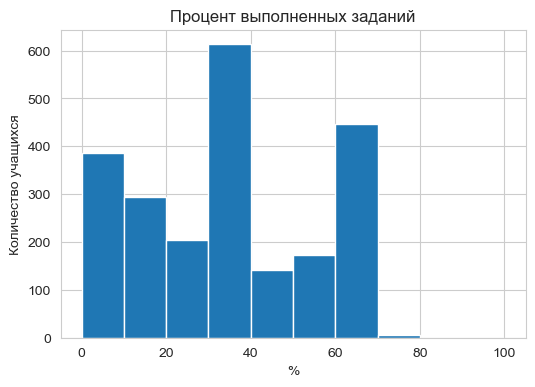

In [82]:
plt.figure(figsize=(6, 4))
plt.hist(df_user_percent['percent_comp_task'], range=(0, 100))
plt.locator_params(axis='y', integer=True)
plt.title('Процент выполненных заданий')
plt.ylabel('Количество учащихся')
plt.xlabel('%')
plt.show()

Смотрим информацию о заданиях курса:
• задания, возможно составленные с ошибкой (задания, имеющие только неудачный попытки решения)
• количество удачных/неудачных попыток по каждому заданию

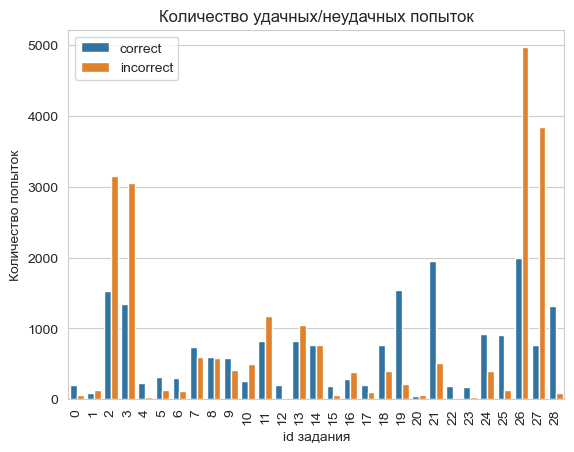

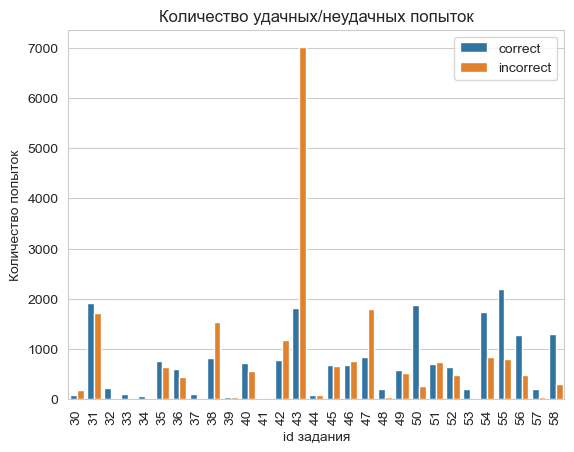

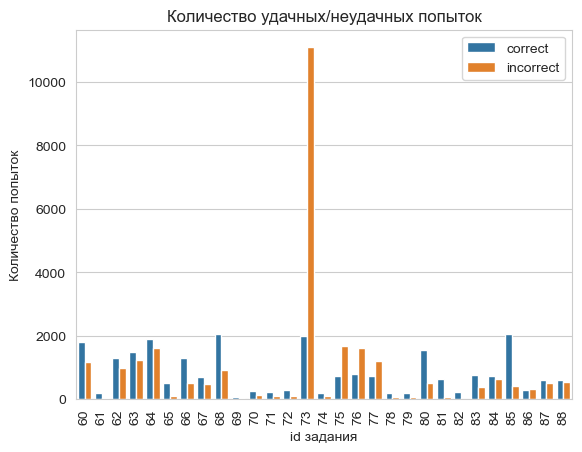

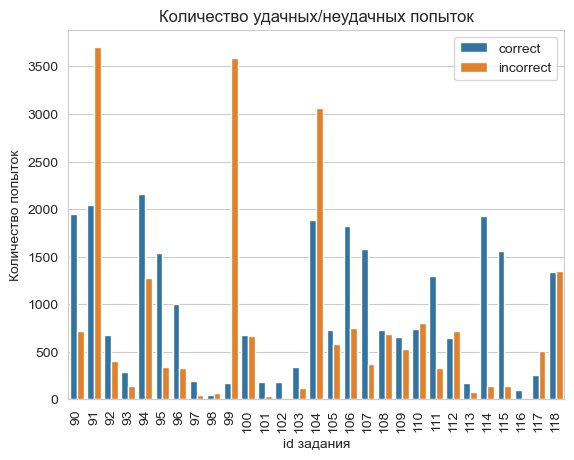

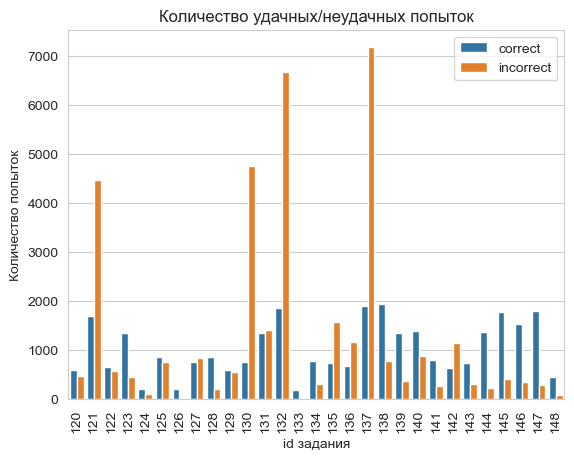

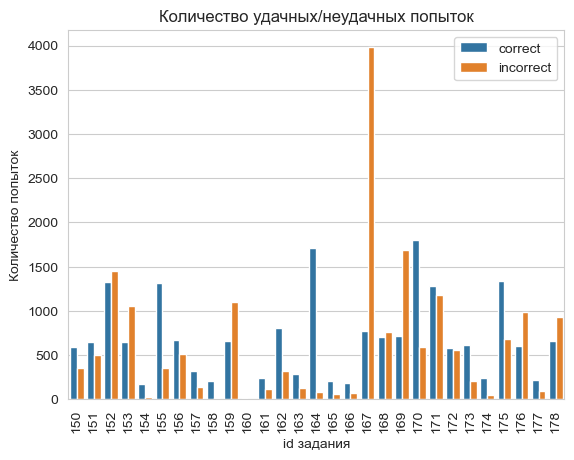

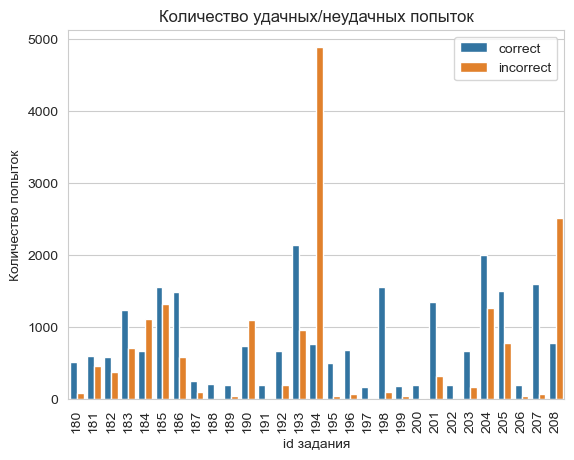

In [83]:
df_succ = df_problem_analysis.\
            rename(columns={'id': 'amount'}).\
            groupby(by=['problem_id', 'success']).\
            count().reset_index()[['problem_id', 'success', 'amount']]
problem_id_map = {i: j for i, j in
                  zip(pd.unique(df_succ['problem_id']), range(0, len(pd.unique(df_succ['problem_id']))))}
df_succ['id_new'] = df_succ['problem_id'].map(problem_id_map)
amount_problem = pd.unique(df_succ.id_new).shape[0]
df_pivot = pd.pivot_table(df_succ, index=['id_new', 'problem_id'], columns='success', values='amount',
                          aggfunc=np.sum).reset_index()
df_task_susp = df_pivot[(df_pivot.correct == 0) & (df_pivot.incorrect > 0)]

if not df_task_susp.empty:
    print('Задания, возможно составленные с ошибкой:')
    print(df_task_susp)

for i in range(0, math.ceil(amount_problem / 30)):
    sns.barplot(data=df_succ.loc[(df_succ.id_new >= i * 30) & (df_succ.id_new < (i + 1) * 30 - 1)], x='id_new',
                y='amount', hue='success')
    plt.legend(title=None)
    plt.xticks(rotation=90)
    plt.title('Количество удачных/неудачных попыток')
    plt.xlabel('id задания')
    plt.ylabel('Количество попыток')
    plt.show()

Смотрим активность на курсе за все время курса

In [84]:
df_problem_analysis = df_problem_analysis.assign(date=lambda x: x.time_event.dt.date).copy()

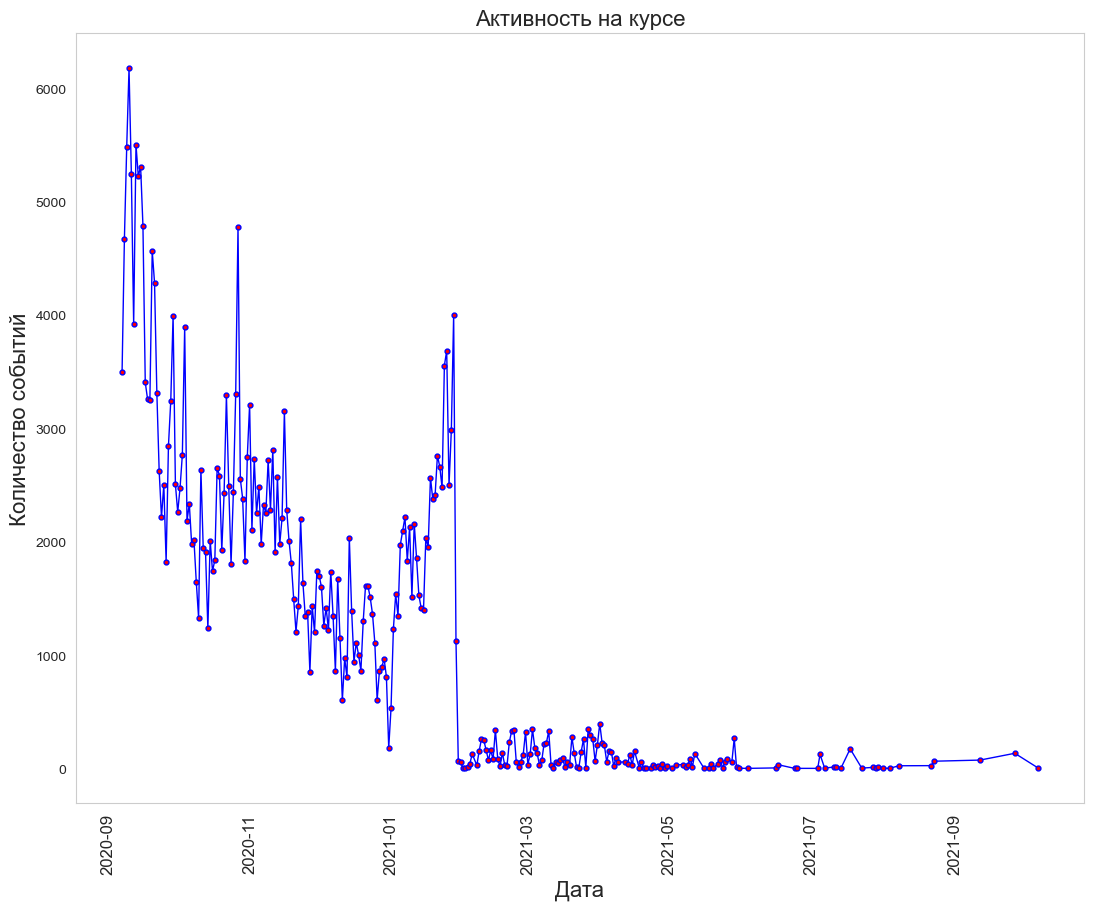

In [85]:
df_temp = df_problem_analysis.groupby(by=['date']).count().reset_index().copy()
plt.figure(figsize=(13, 10))
plt.plot(df_temp['date'], df_temp['id'], '.-b', mfc='r', ms=7, linewidth=1)
plt.xticks(rotation=90, fontsize=12)
plt.title('Активность на курсе', fontsize=16)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Количество событий', fontsize=16)
plt.grid()
plt.show()

Смотрим среднюю активность пользователя на курсе в течение дня

In [86]:
df_problem_analysis = df_problem_analysis.assign(hour=lambda x: x.time_event.dt.hour)

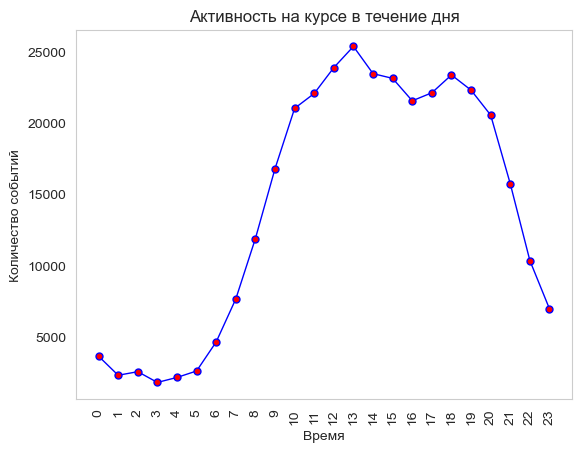

In [87]:
df_temp = df_problem_analysis.groupby(by=['hour']).count().reset_index()
plt.plot(df_temp['hour'], df_temp['id'], '.-b', mfc='r', ms=10, linewidth=1)
plt.xticks(np.arange(min(df_temp['hour']), max(df_temp['hour']) + 1, 1), rotation=90)
plt.title('Активность на курсе в течение дня')
plt.xlabel('Время')
plt.ylabel('Количество событий')
plt.grid()
plt.show()

In [88]:
df_time = df_problem_analysis.groupby('user_id')['time_event'].max() - df_problem_analysis.groupby('user_id')['time_event'].min()
print('Среднее время участия студента на курсе: ', str(df_time.mean()).split(".")[0])

Среднее время участия студента на курсе:  49 days 09:46:31


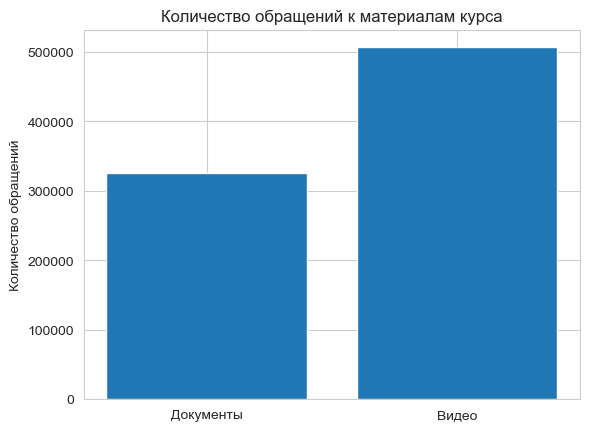

In [89]:
plt.bar(['Документы', 'Видео'], [df_book_analysis.shape[0], df_video_analysis.shape[0]])
plt.title('Количество обращений к материалам курса')
plt.ylabel('Количество обращений')
plt.show()

Кластеризуем студентов

Подготавливаем данные.

Множество признаков состоит из:
• количества взаимодействий с курсом в течение каждого периода;
• количества попыток, потраченных на выполнение каждого задания;
• количества взаимодействий с видео и с текстовыми материалами;
• процента успешности выполнения курса.

In [ ]:
df_problem = df_problem.assign(seasons=df_problem['time_event'].dt.strftime('%m-%y'))
df_problem = df_problem.assign(action=1)
df_clast_seasons = pd.pivot_table(df_problem, index='user_id', columns='seasons', values='action', aggfunc=np.sum,
                                  fill_value=0)
df_clast_seasons = df_clast_seasons.reindex(
    columns=pd.Series(sorted(pd.to_datetime(df_clast_seasons.columns.to_list(), format="%m-%y"))).dt.strftime(
        "%m-%y"))
df_clast_seasons.columns.name = None
df_clast_seasons.columns = pd.MultiIndex.from_product([['seasons'], df_clast_seasons.columns])
problem_id_map = {i: j for i, j in
                  zip(pd.unique(df_problem['problem_id']), range(0, len(pd.unique(df_problem['problem_id']))))}
df_problem = df_problem.assign(problem_id_num=df_problem['problem_id'].map(problem_id_map))
df_clast_problem = df_problem.pivot_table(index="user_id", columns="problem_id_num", values='attempts',
                                          fill_value=0, aggfunc=np.max)
df_clast_problem.columns.name = None
df_clast_problem.columns = pd.MultiIndex.from_product([['problem_id'], df_clast_problem.columns.astype(str)])
df_clast_video_book = df_video.groupby(by='user_id').count()[['video_id']].merge(
    df_book.groupby(by='user_id').count()[['chapter']], on='user_id', how='outer')
df_user_percent = pd.DataFrame(columns=['user_id', 'percent'])
amount_of_problem = pd.unique(df_problem['problem_id']).shape[0]
for i in pd.unique(df_problem['user_id']):
    df_user_percent.loc[len(df_user_percent)] = [i, df_problem[
        (df_problem.user_id == i) & (df_problem.success == 'correct')].shape[
        0] / amount_of_problem * 100]
df_clast_others = df_clast_video_book.merge(df_user_percent, on='user_id', how='outer')
df_clast_others = df_clast_others.set_index('user_id').fillna(0)
df_clast_others.columns = pd.MultiIndex.from_product([['others'], df_clast_others.columns])
df_all = df_clast_seasons.merge(df_clast_problem, on='user_id', how='outer').merge(df_clast_others, on='user_id',
                                                                                   how='outer')
df_all = df_all.loc[df_all.others.percent != 0]

Стандартизируем и кластеризуем

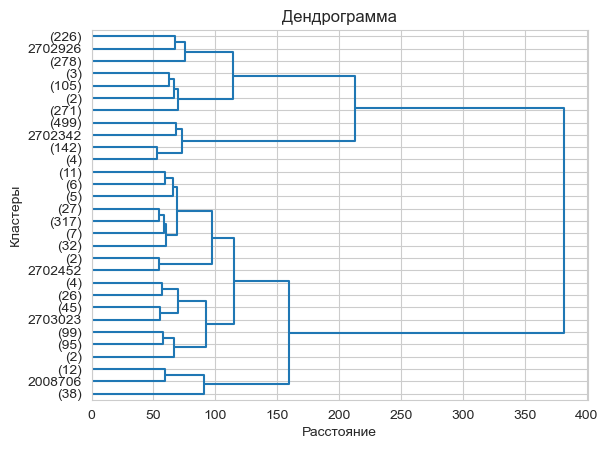

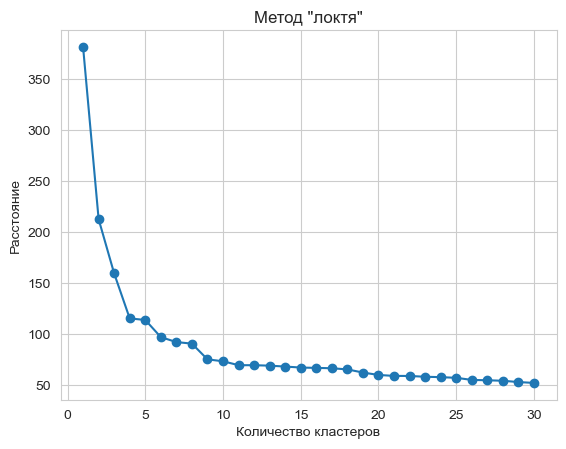

In [96]:
X = df_all.copy()
X.columns = X.columns.droplevel()
norm = preprocessing.StandardScaler()
norm.fit(X)
X_norm = norm.transform(X)
X_norm = pd.DataFrame(X_norm, index=X.index, columns=X.columns)

link = linkage(X_norm.to_numpy(), 'ward', 'euclidean')
dendrogram(link, labels=np.array(X_norm.index), truncate_mode='lastp', color_threshold=5, orientation="right",
           leaf_rotation=0.)
plt.title('Дендрограмма')
plt.ylabel('Кластеры')
plt.xlabel('Расстояние')
plt.show()

dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs[:30], dist_rev[:30], marker='o')
plt.title('Метод "локтя"')
plt.xlabel('Количество кластеров')
plt.ylabel('Расстояние')
plt.show()

Выбираем количество кластеров

In [97]:
n_cluster = int(input('Введите количество кластеров: '))
df_all['cluster'] = fcluster(link, n_cluster, criterion='maxclust')
print(df_all.groupby('cluster').size())

cluster
1     51
2    680
3    646
4    886
dtype: int64


Проинтерпретируем полученные кластеры, построив некоторые графики

Среднее число взаимодействий с курсом по периодам

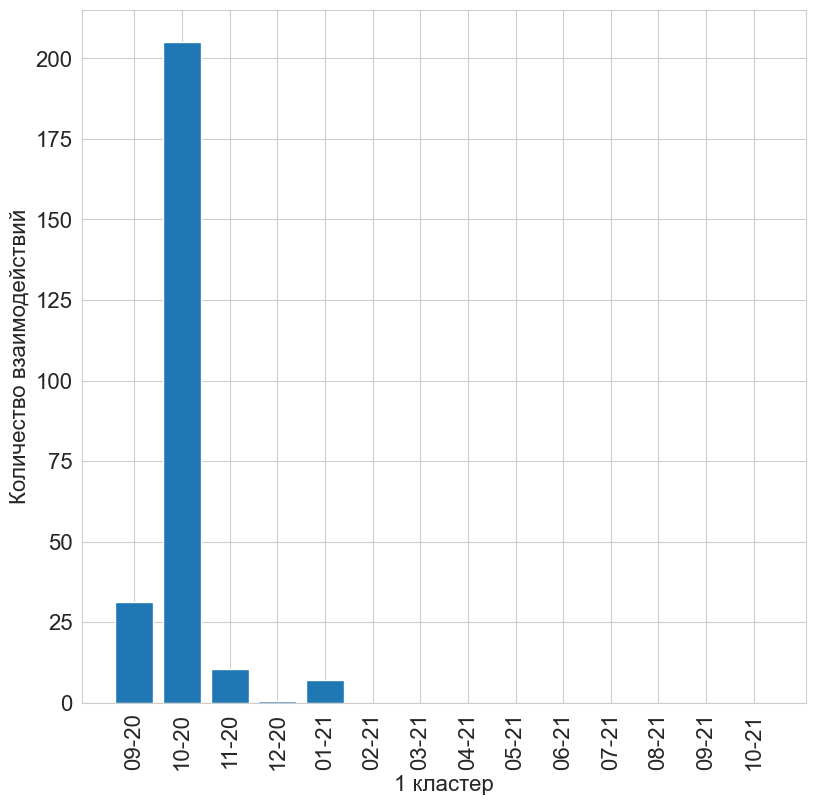

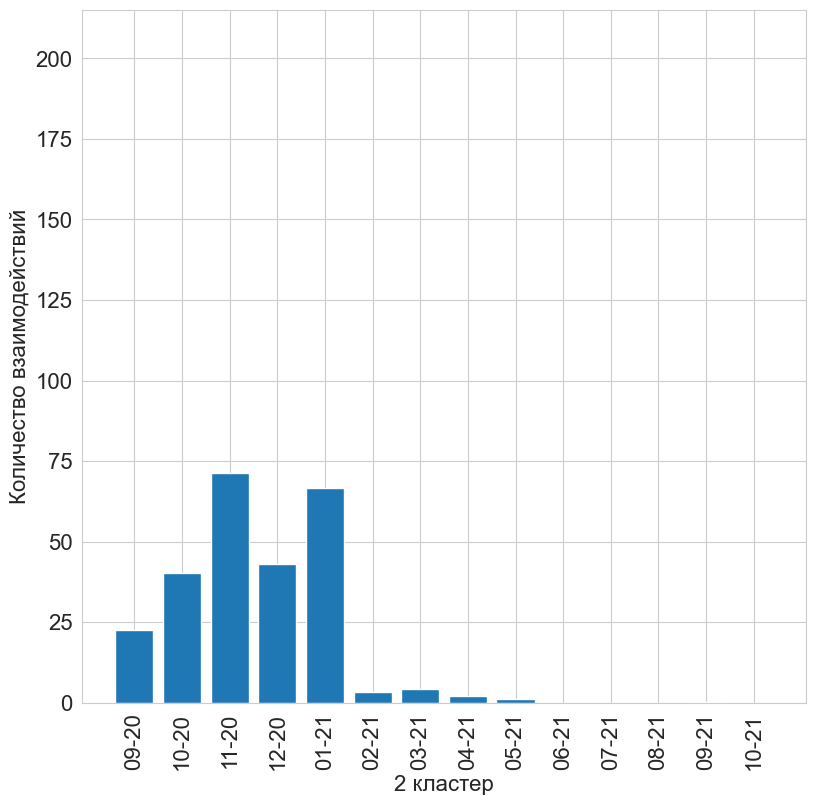

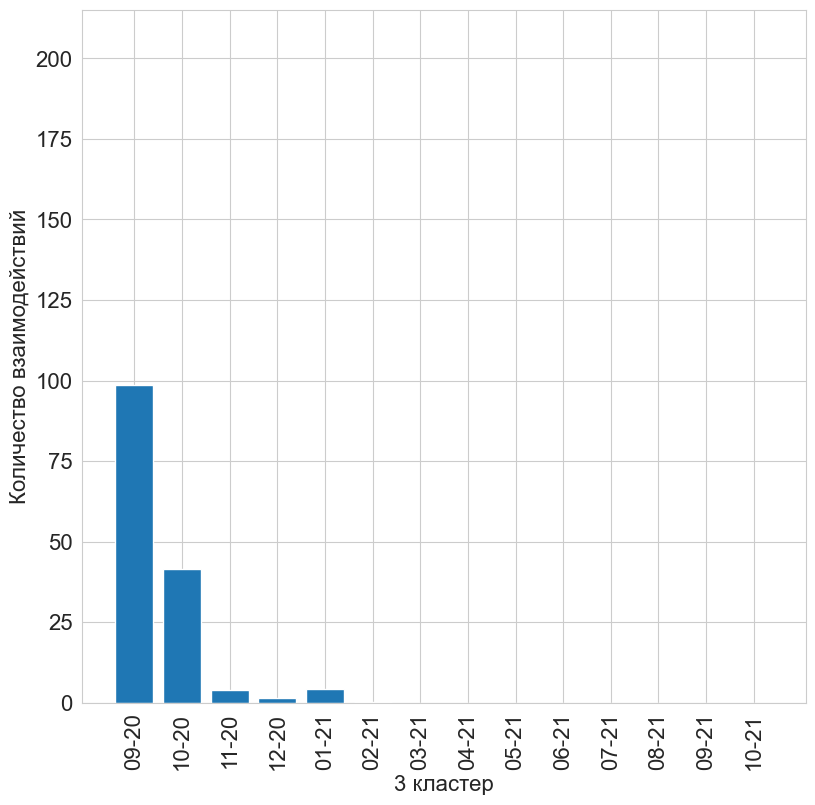

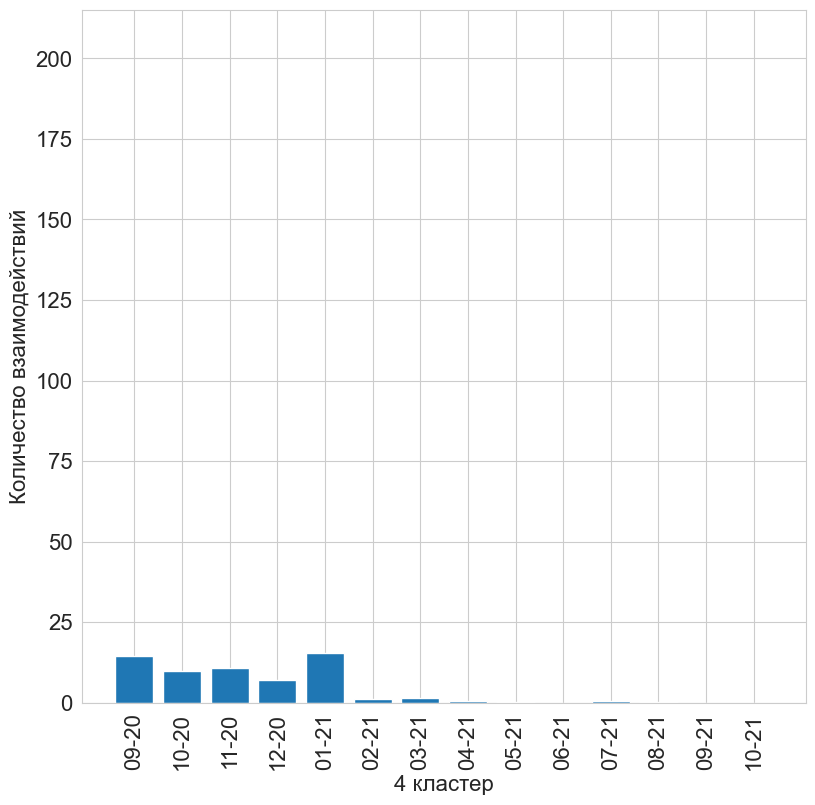

In [98]:
df_temp = df_all[['seasons', 'cluster']].copy()
df_temp.columns = df_temp[['seasons', 'cluster']].columns.droplevel()
df_temp.rename(columns={'': 'cluster'}, inplace=True)
df_mean_T = df_temp.groupby('cluster').mean().T
y_max = df_mean_T.max().max()
for i in df_mean_T.columns:
    plt.figure(figsize=(df_mean_T.shape[0] / 1.5, 9))
    plt.bar(df_mean_T[[i]].index, df_mean_T[i])
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel(str(i) + ' кластер', fontsize=16)
    plt.xticks(rotation=90)
    plt.ylim(0, y_max + 10)
    plt.ylabel('Количество взаимодействий', fontsize=16)
    plt.show()

Среднее число попыток выполнения заданий

<Figure size 2000x1000 with 0 Axes>

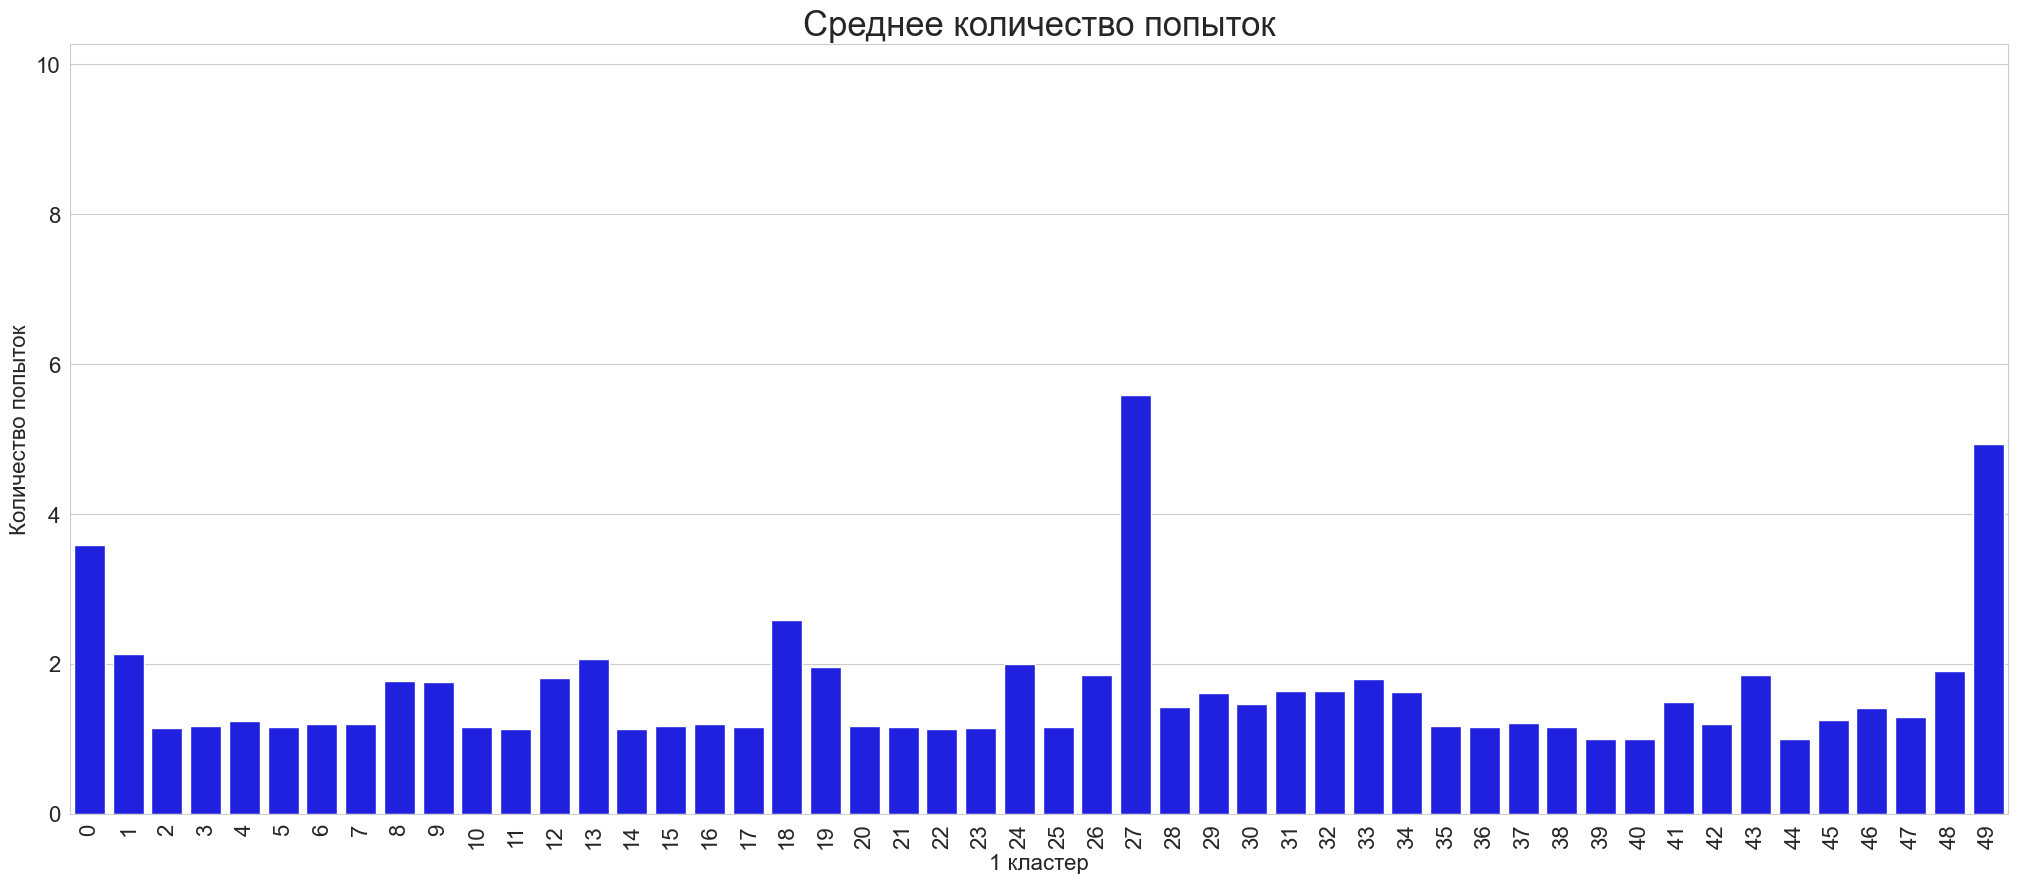

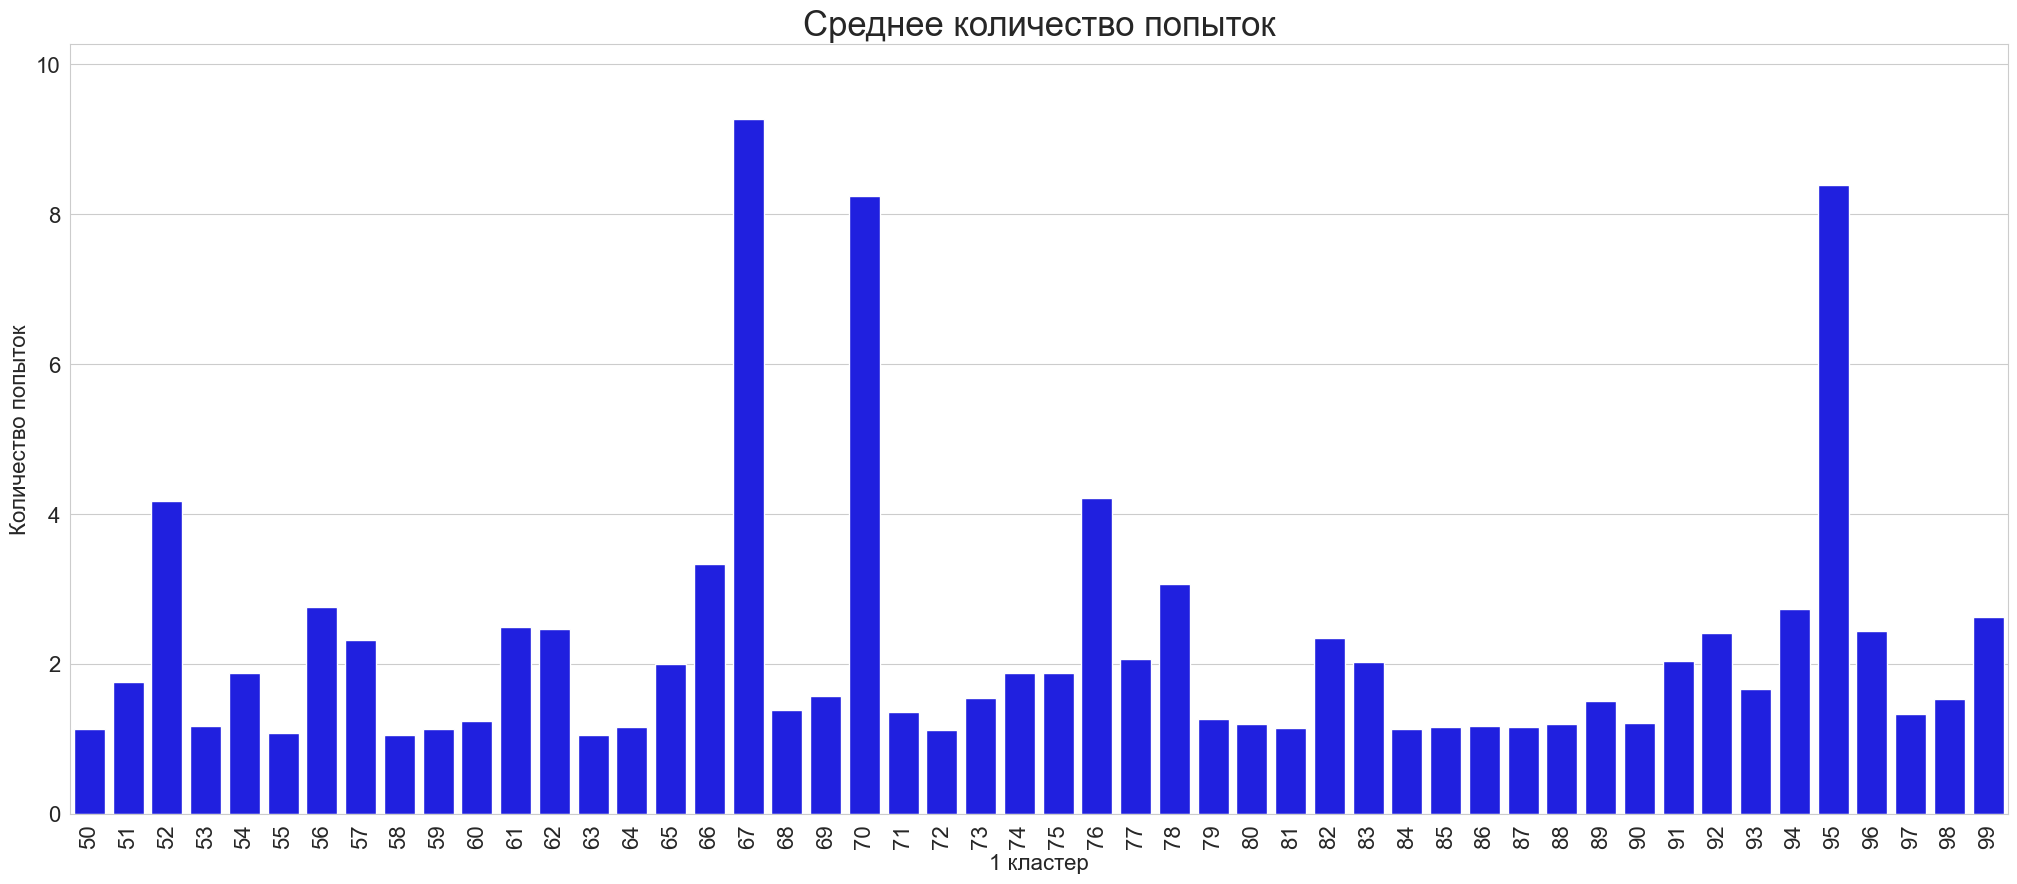

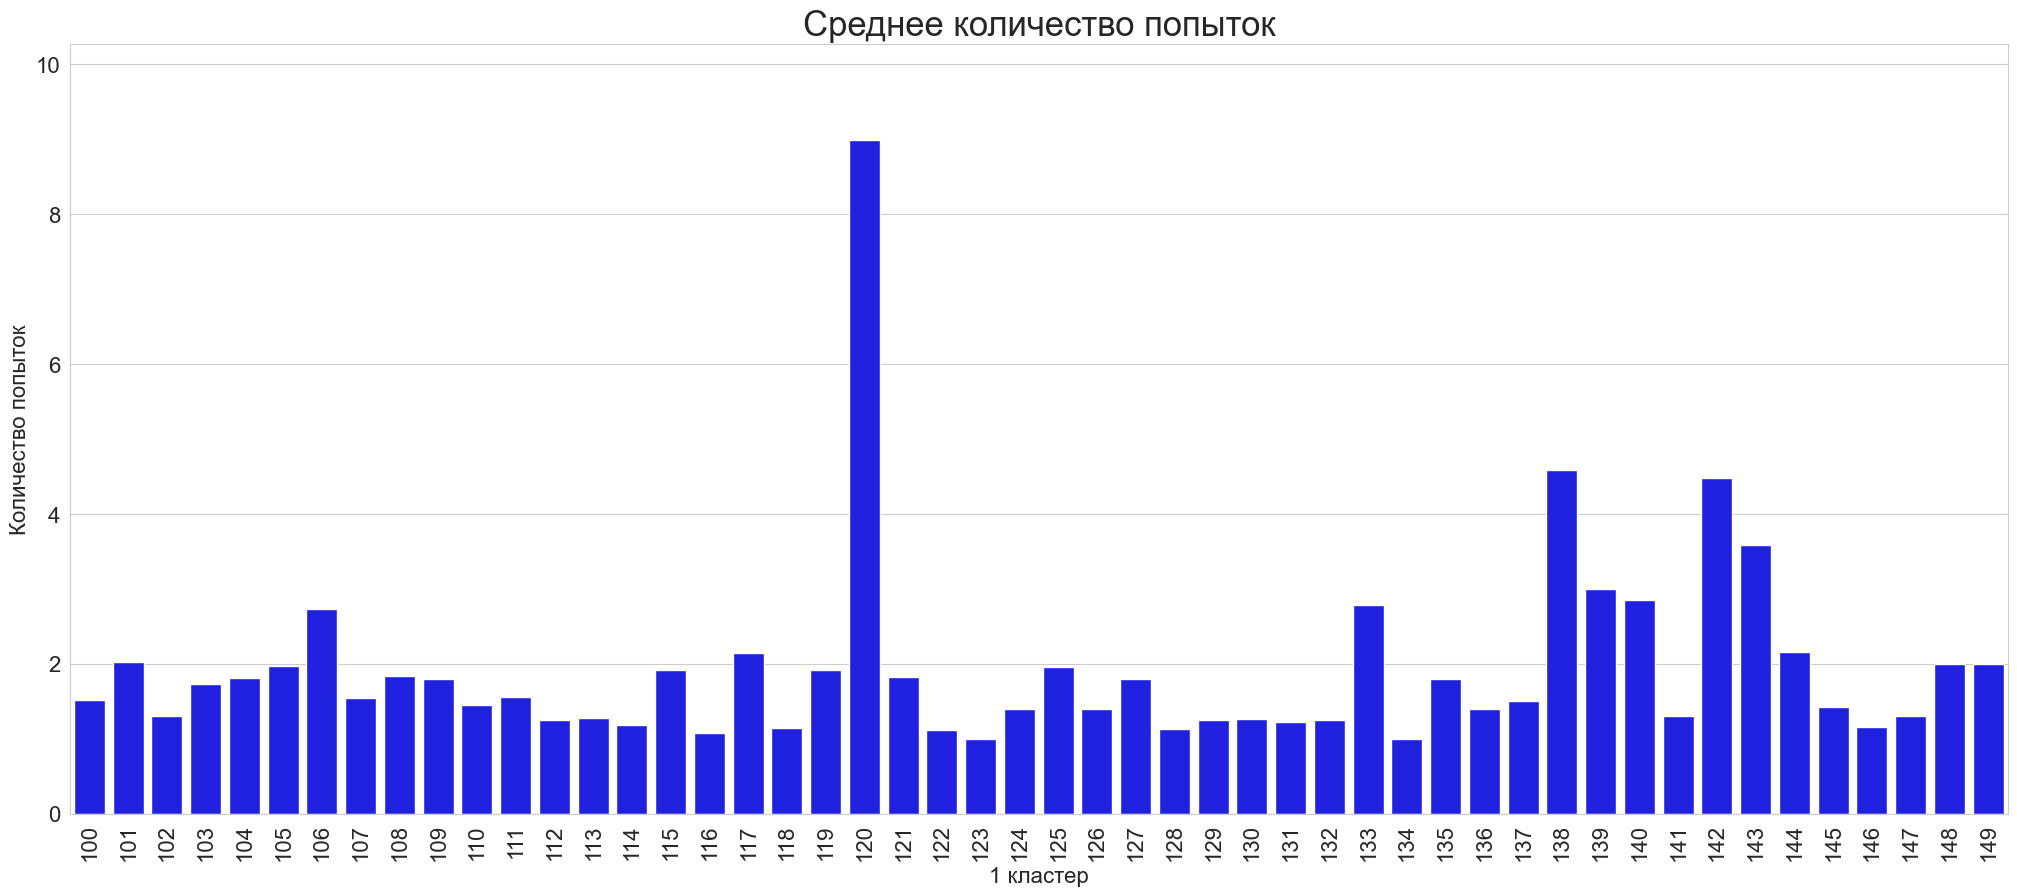

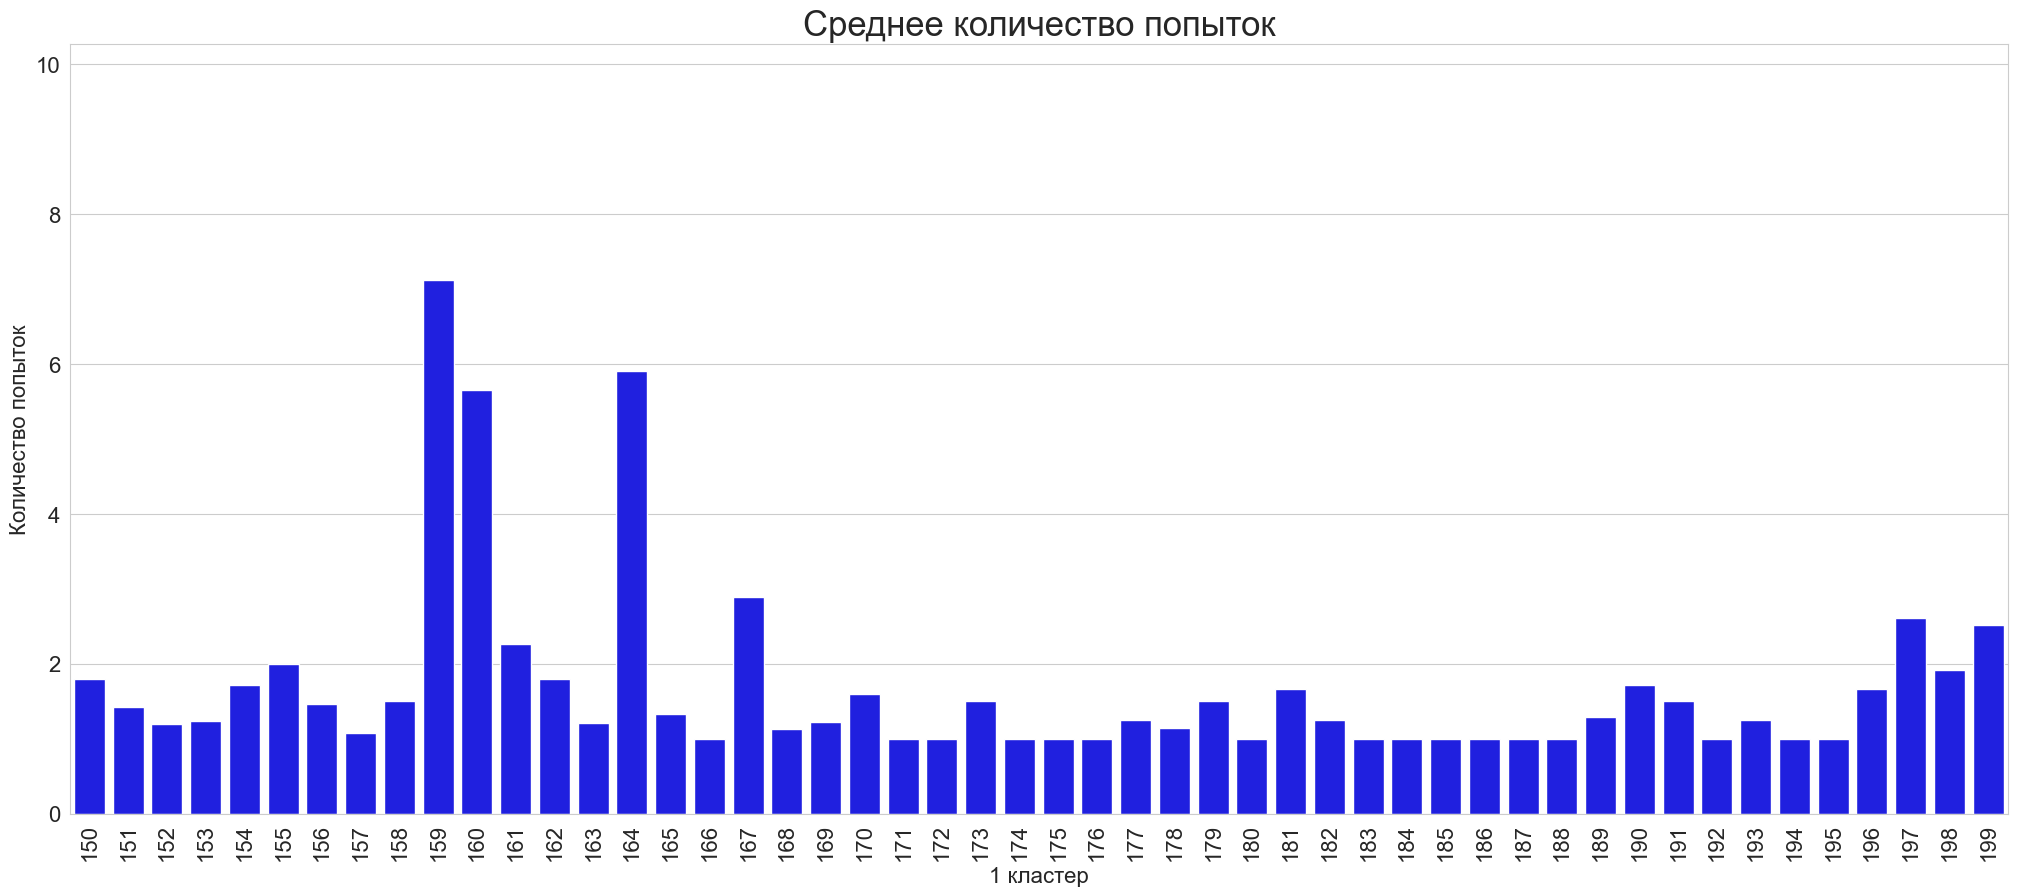

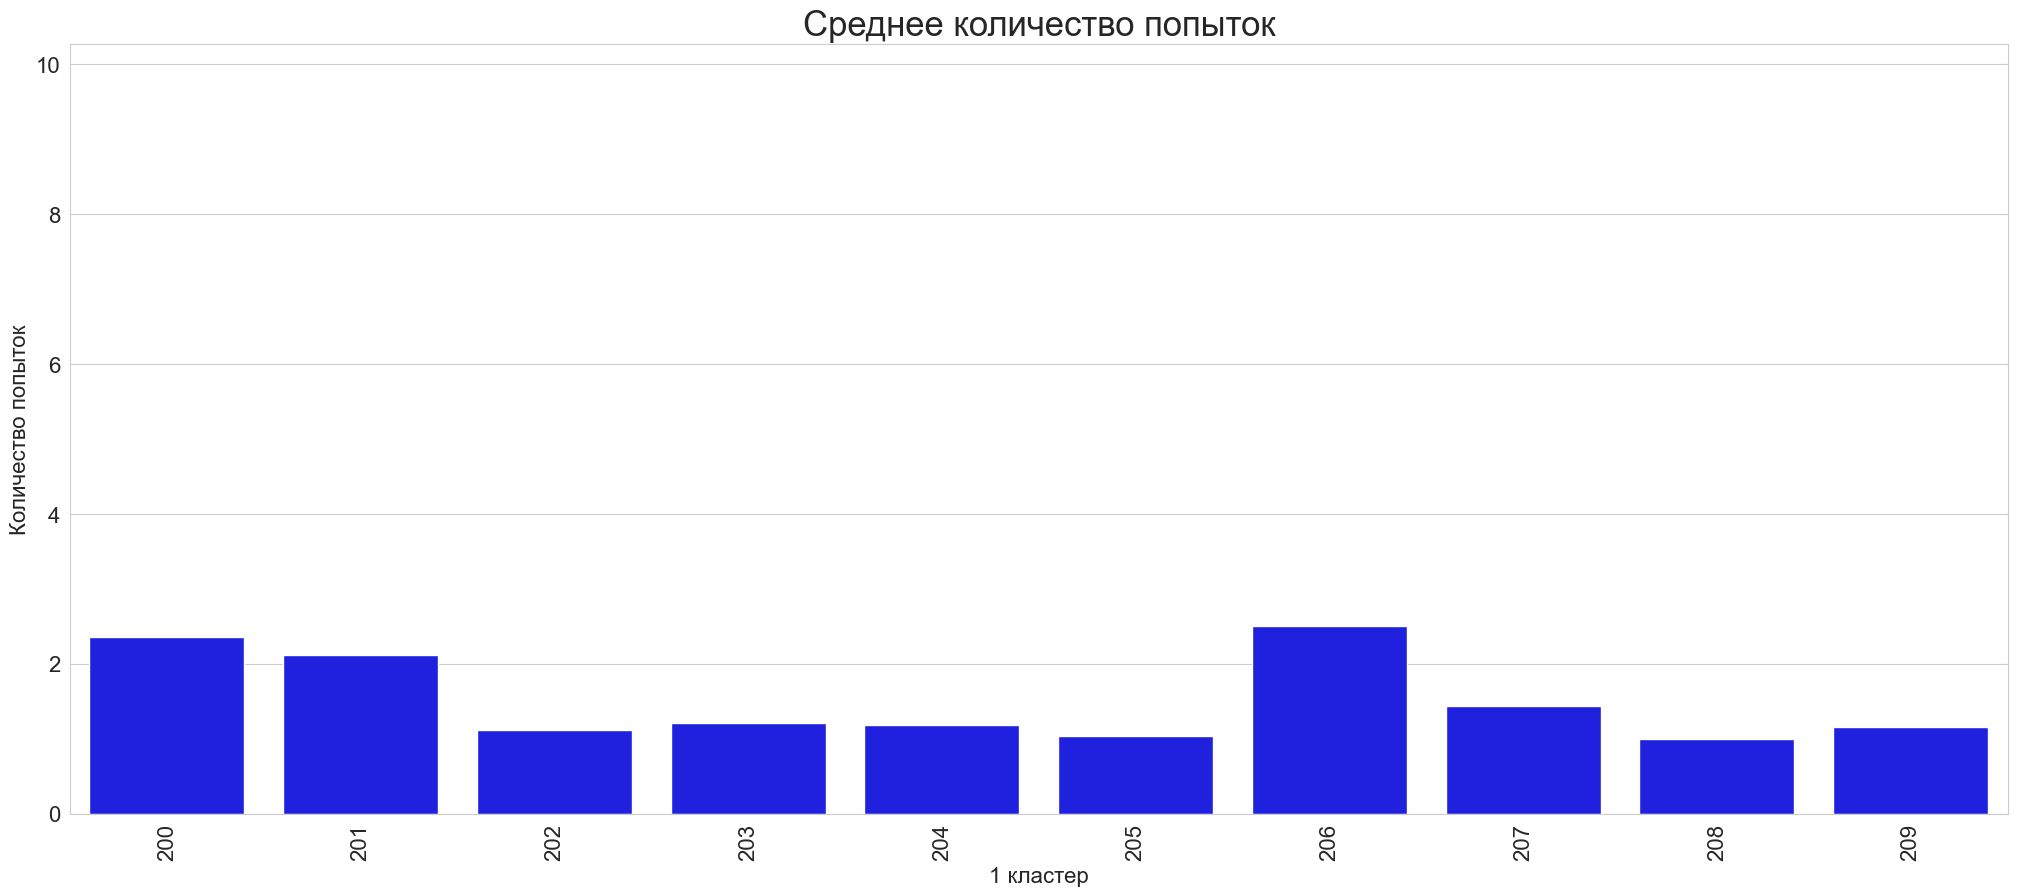

<Figure size 2000x1000 with 0 Axes>

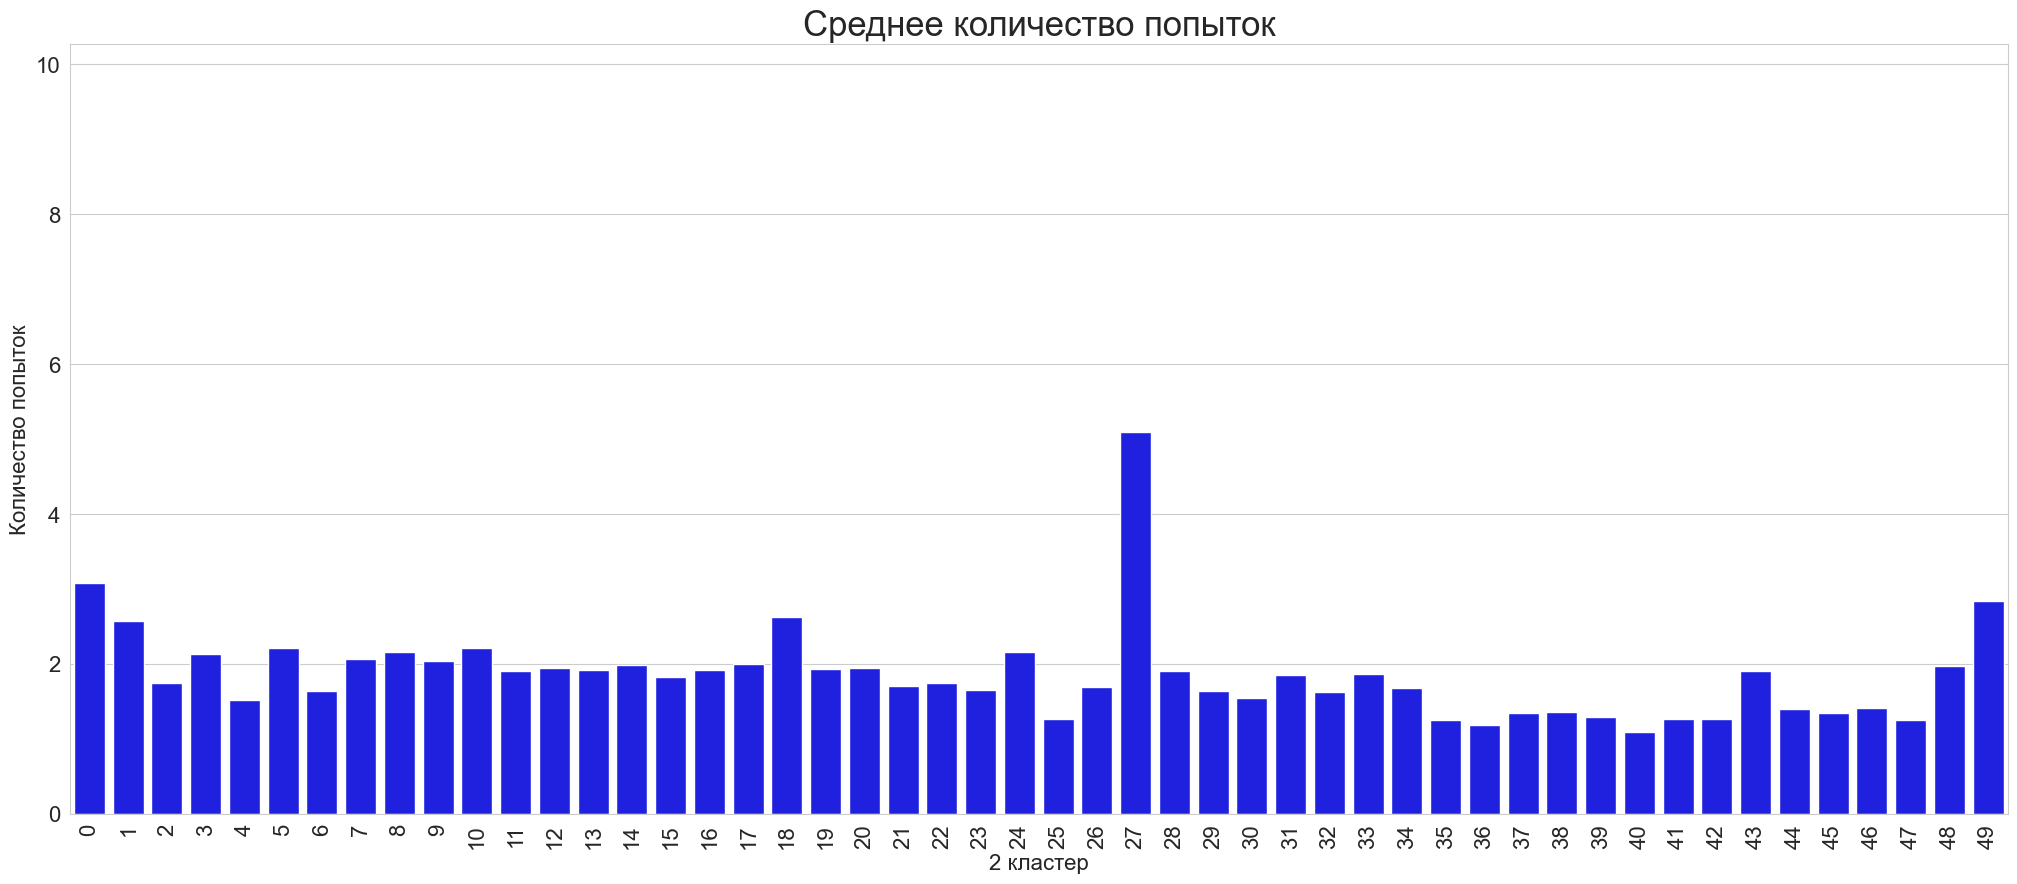

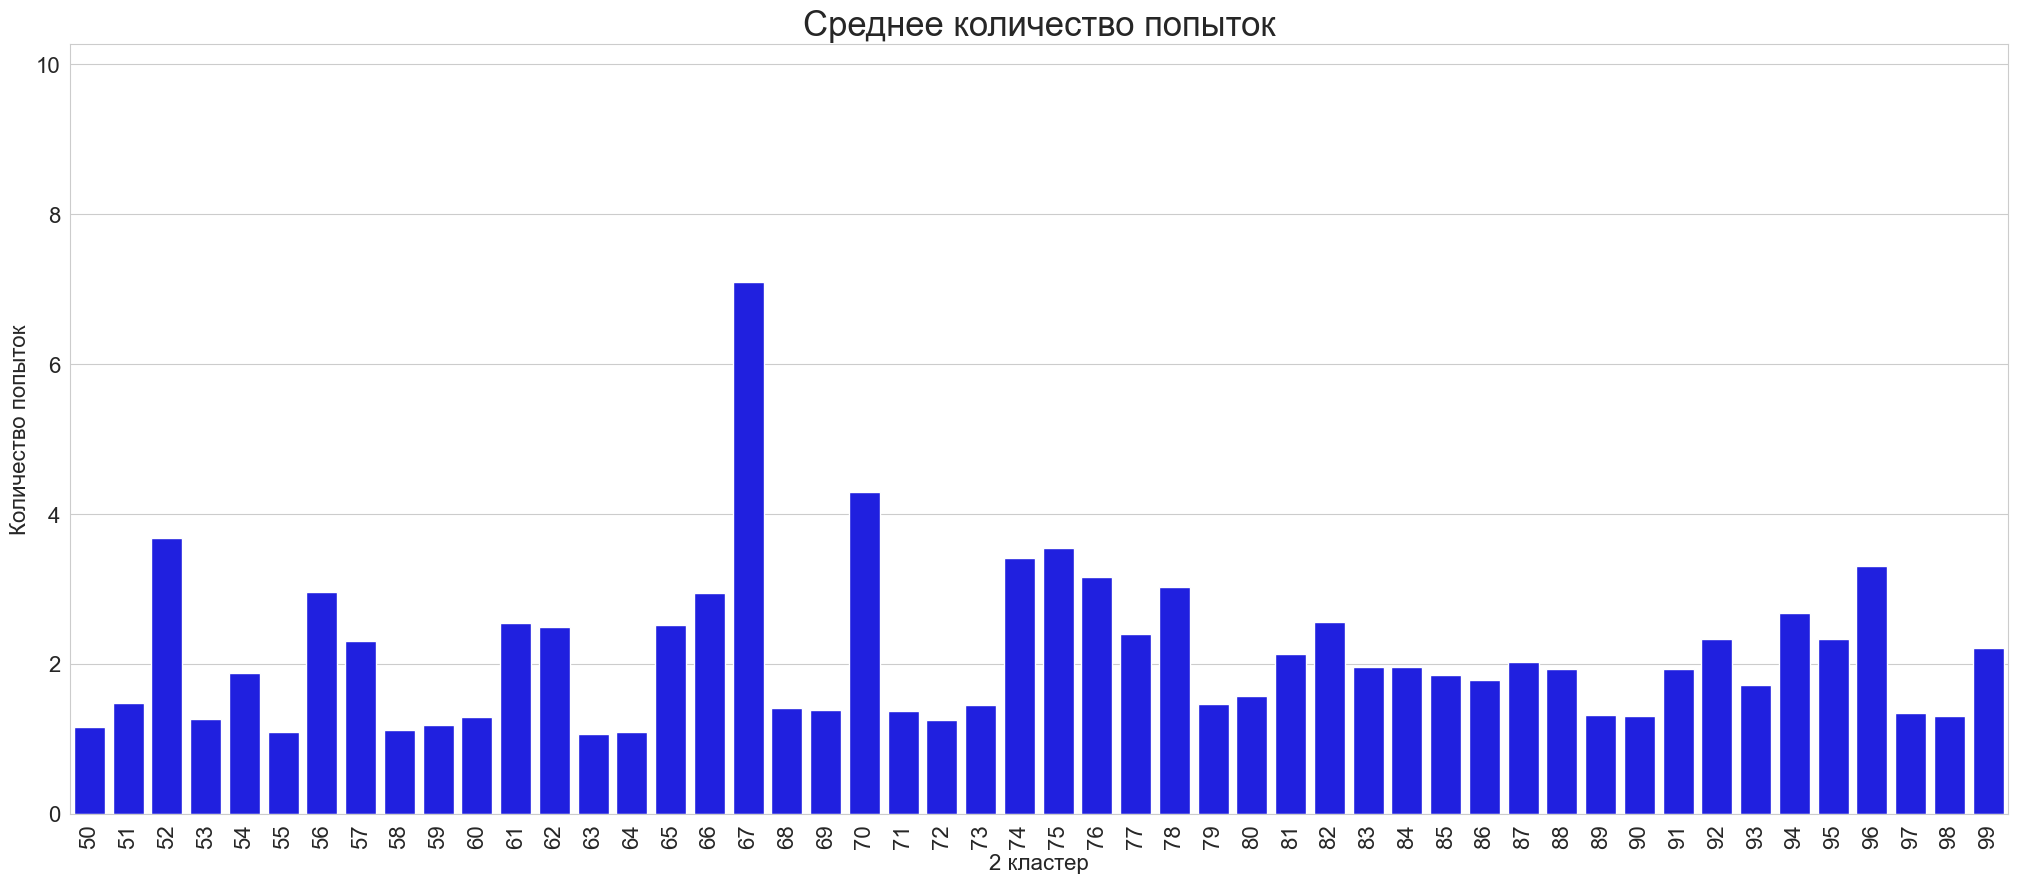

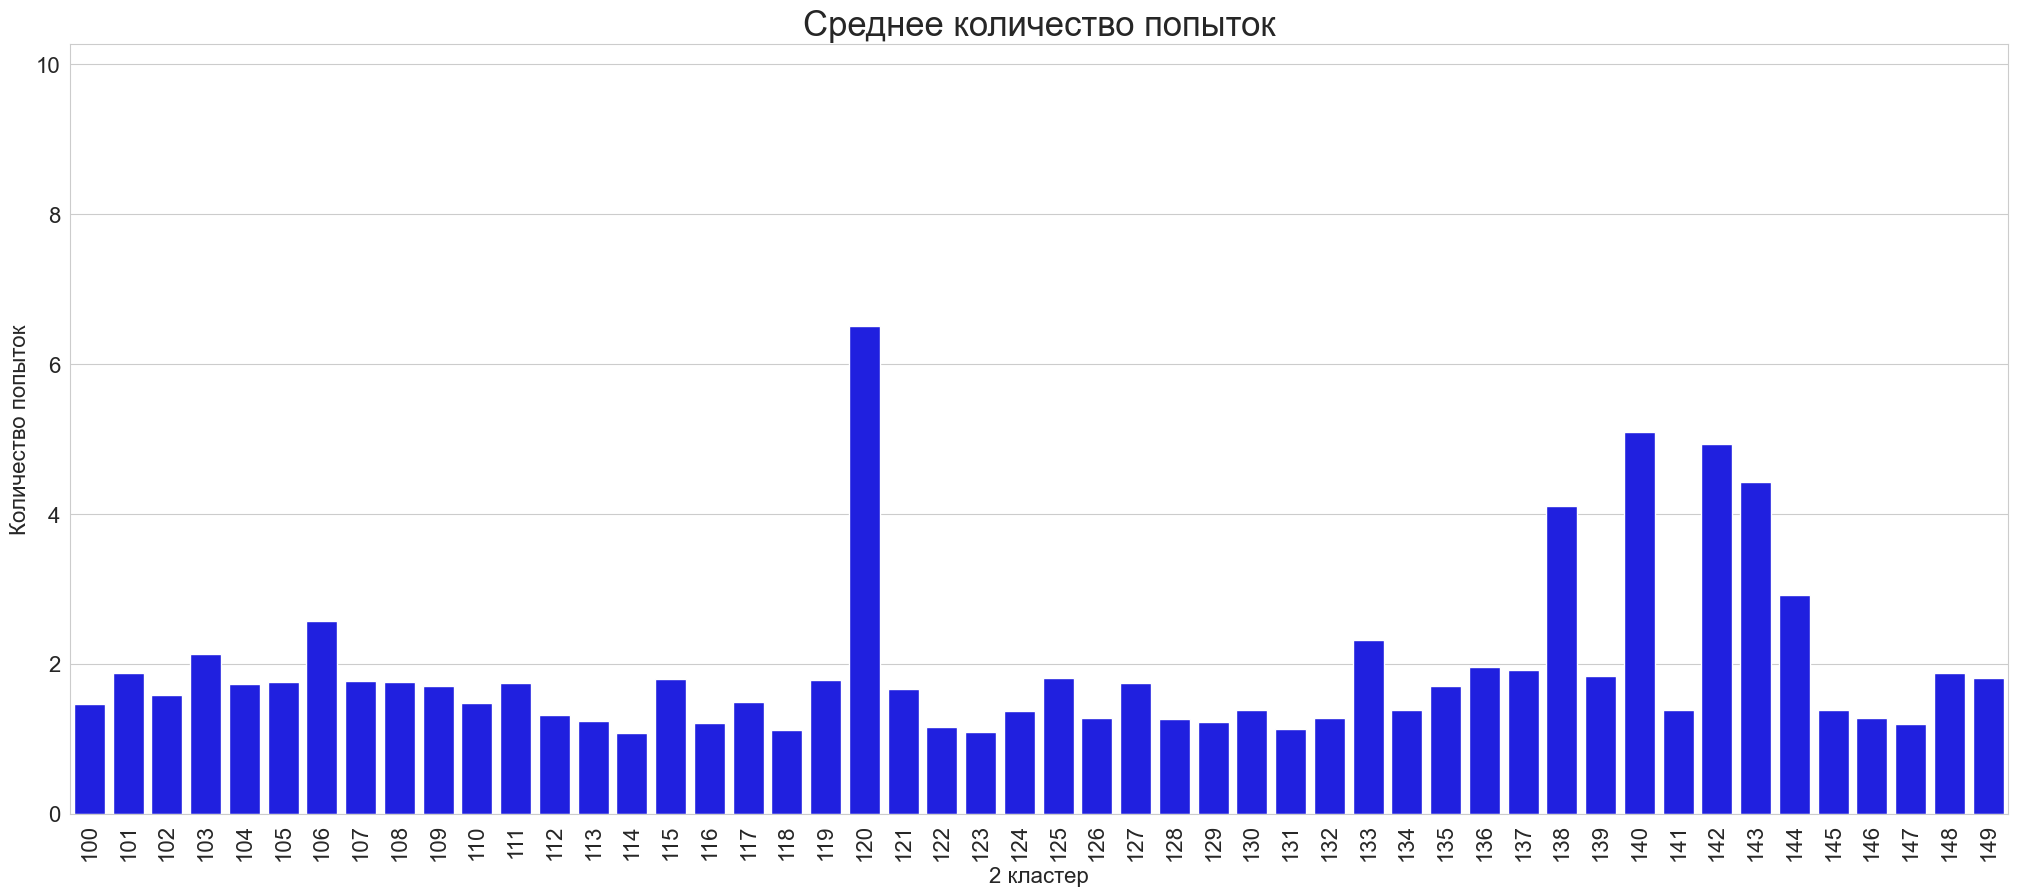

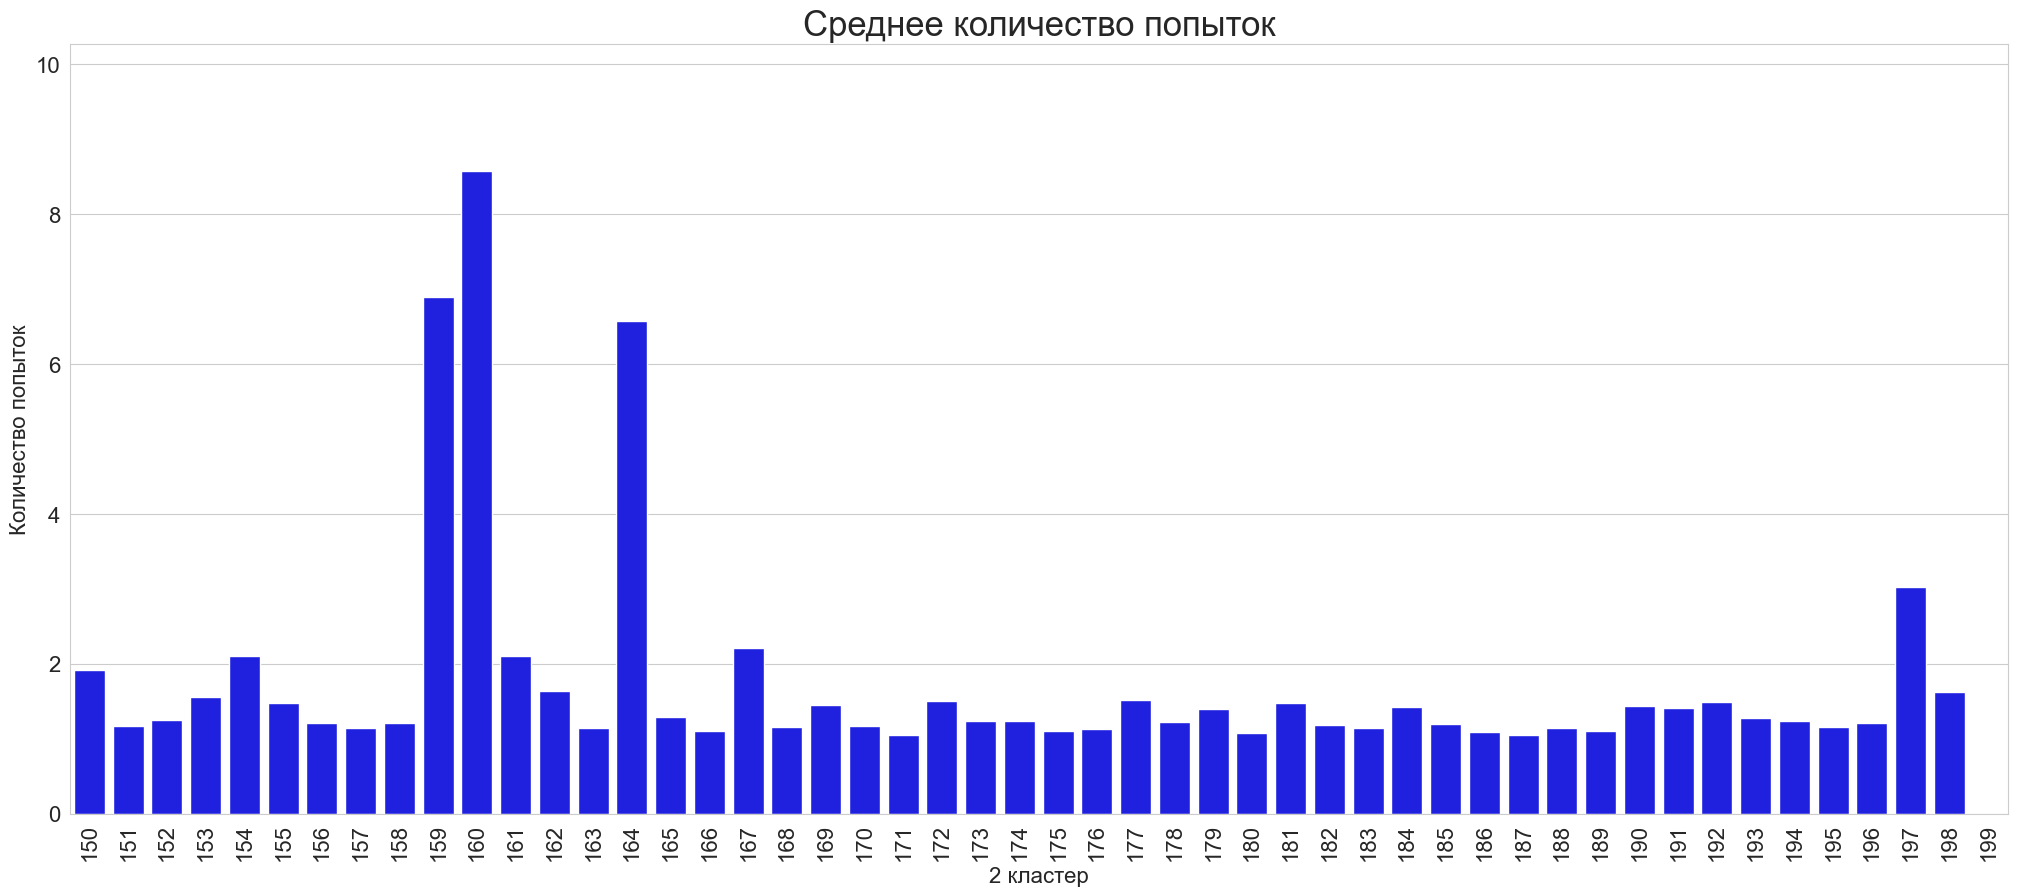

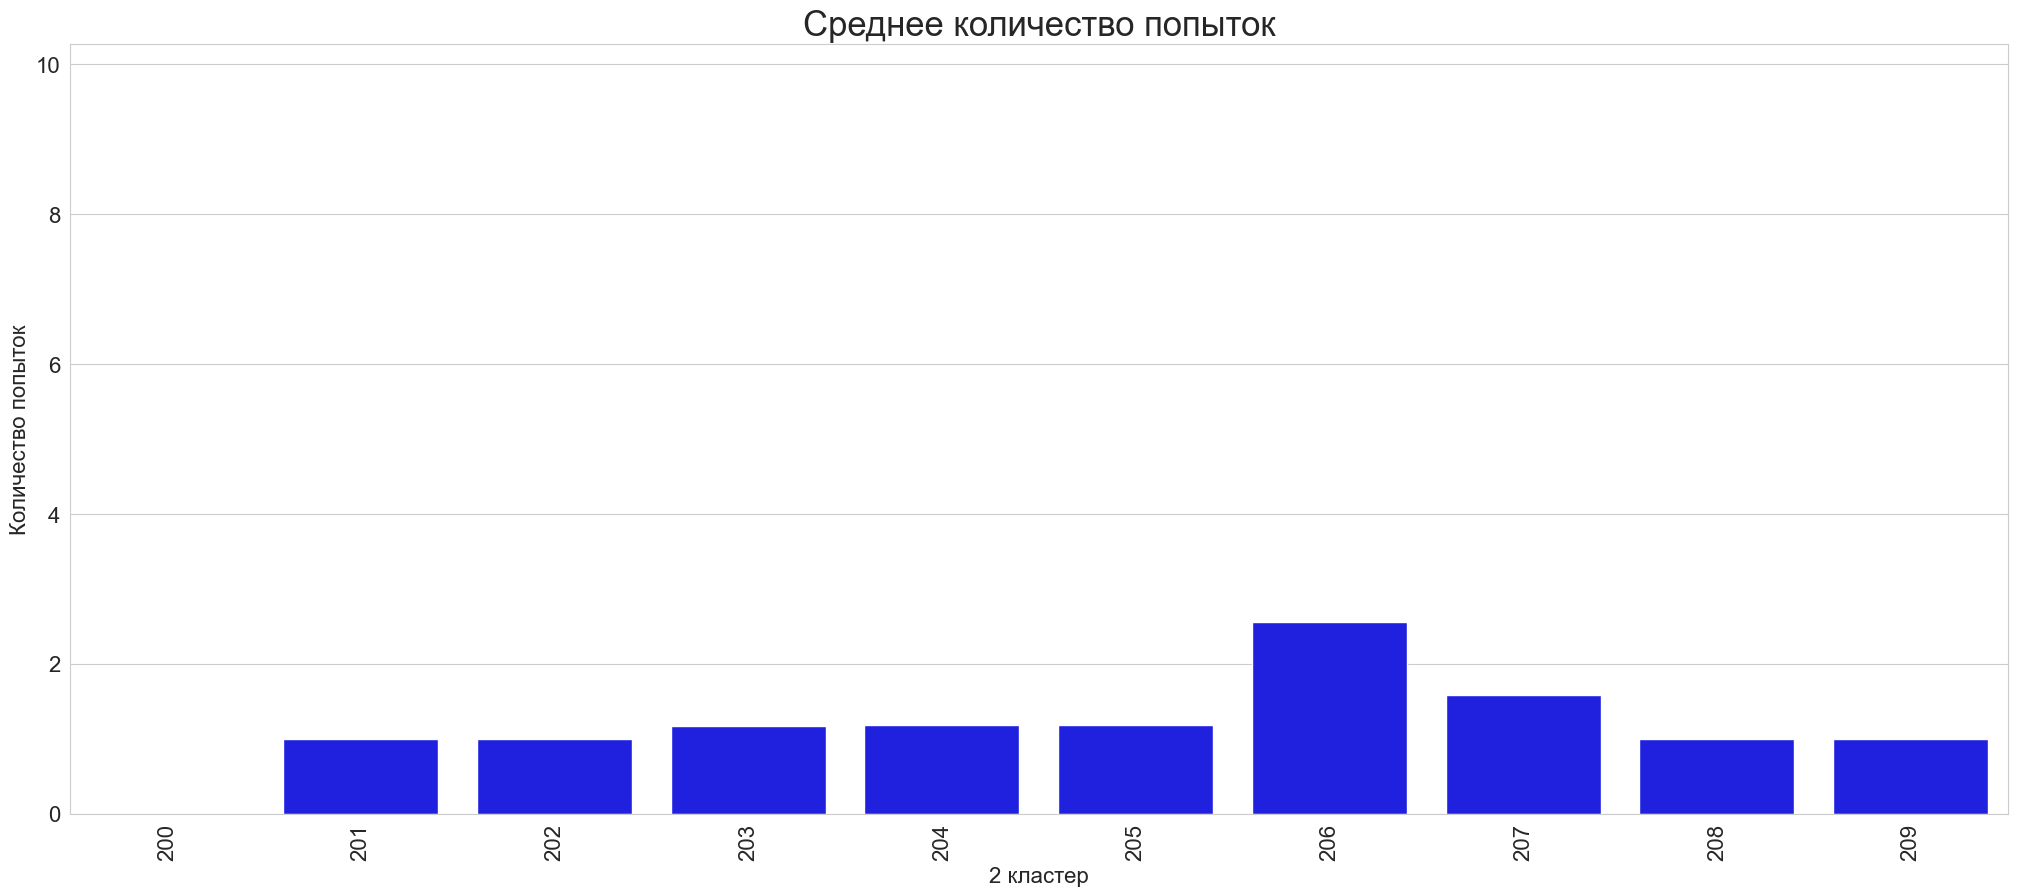

<Figure size 2000x1000 with 0 Axes>

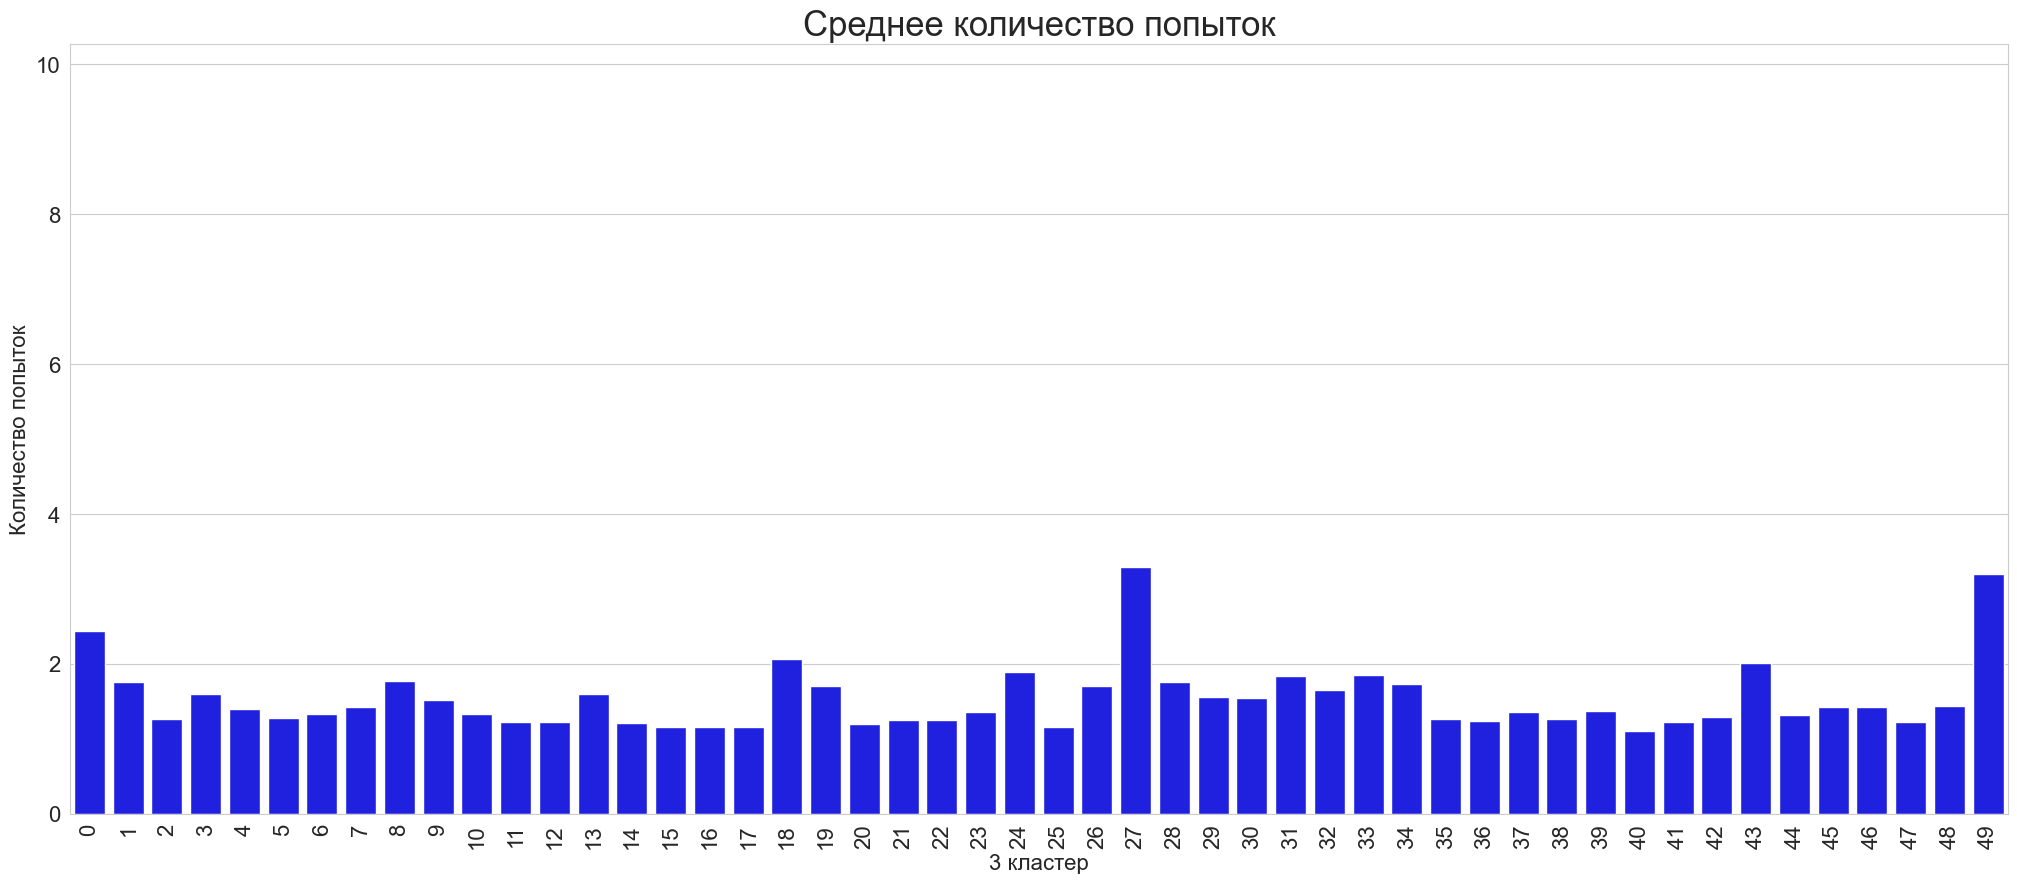

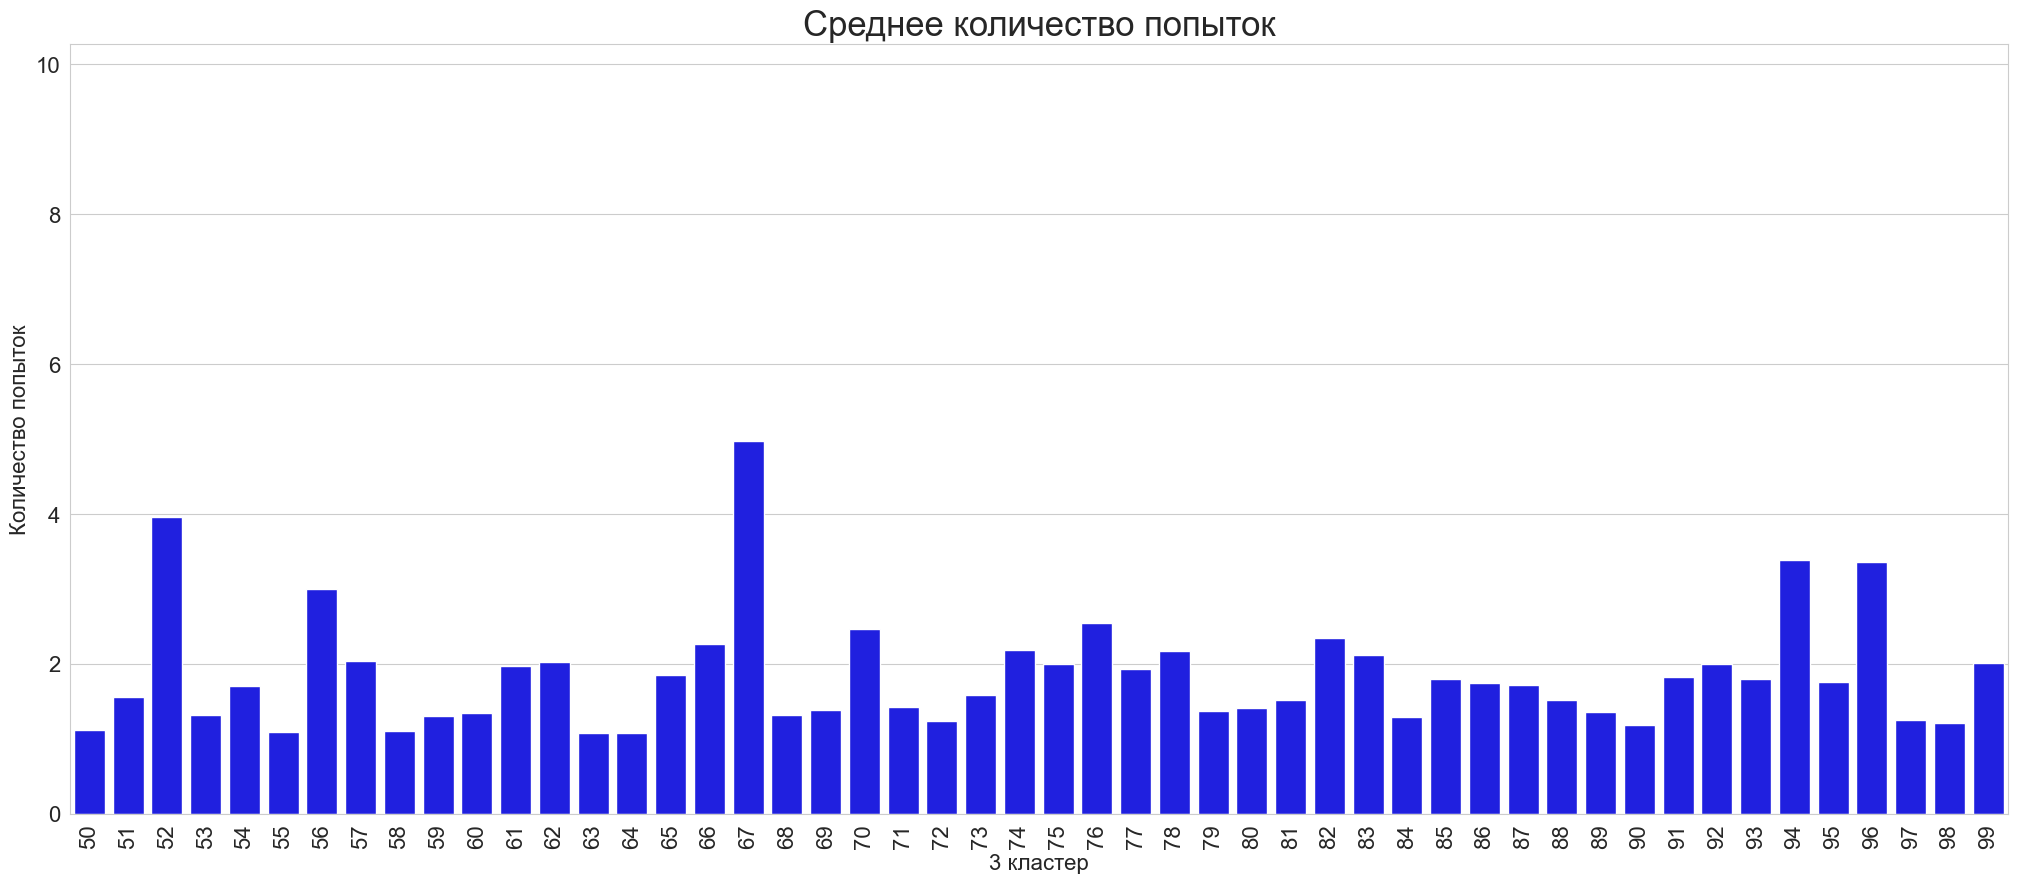

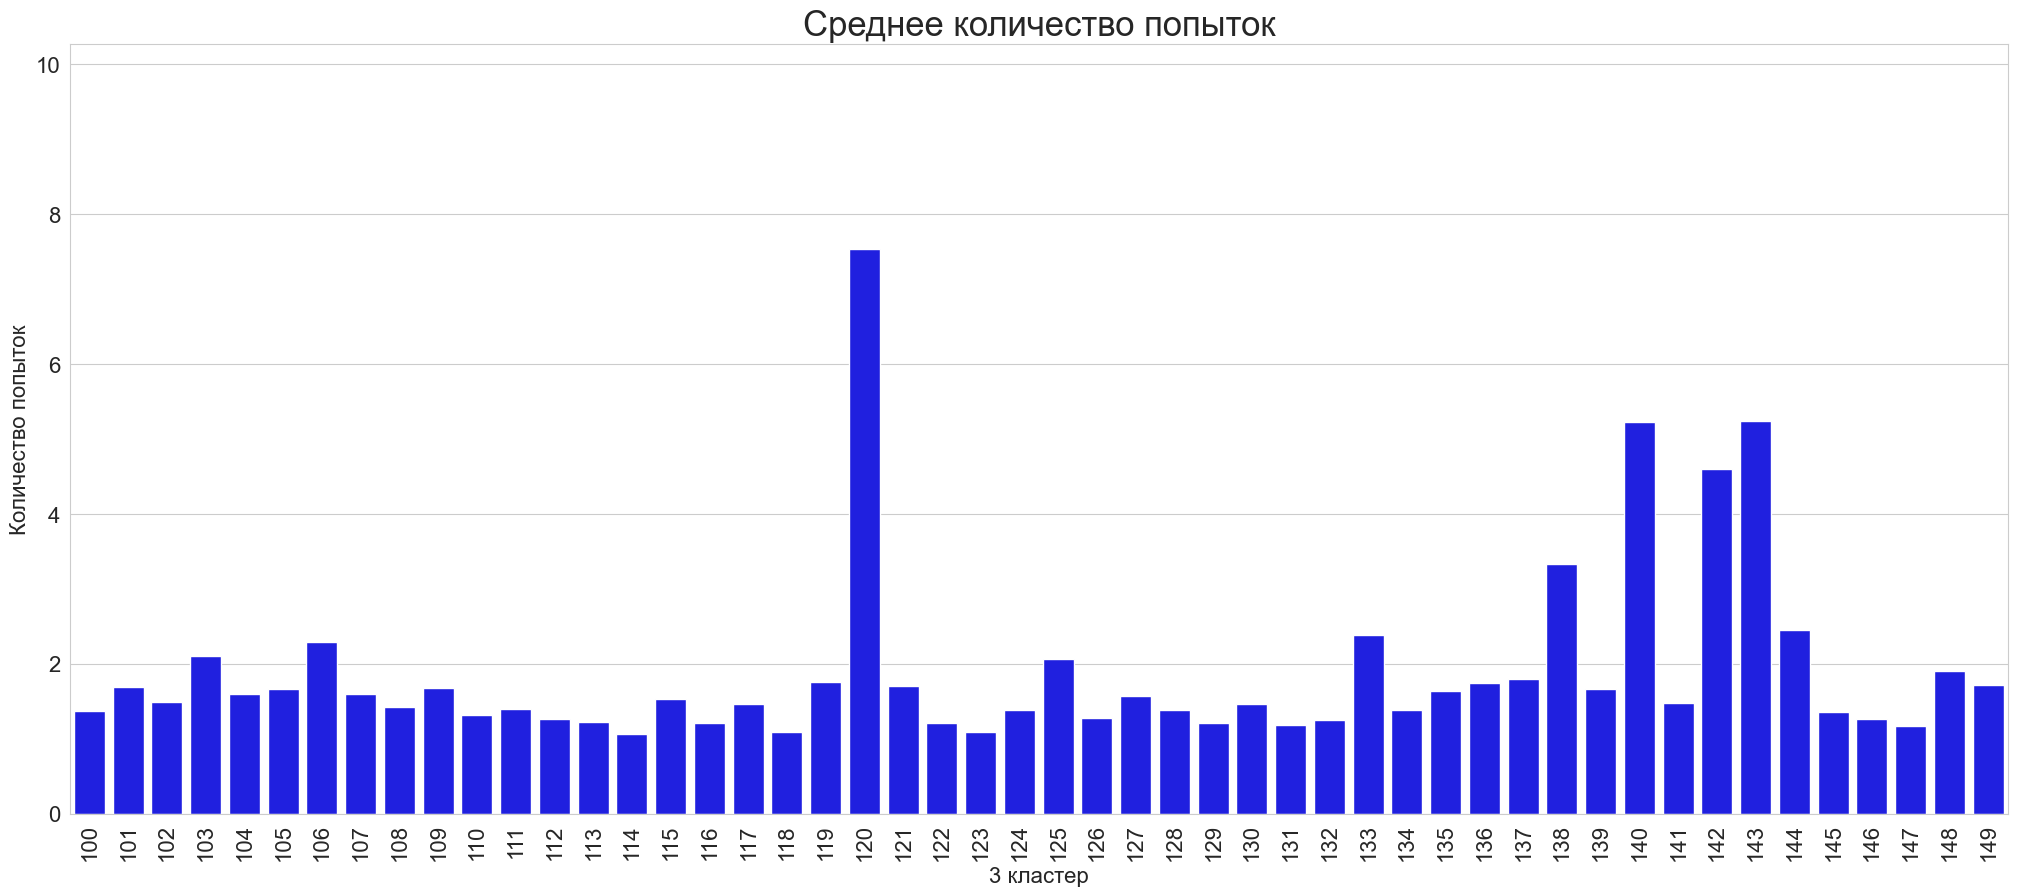

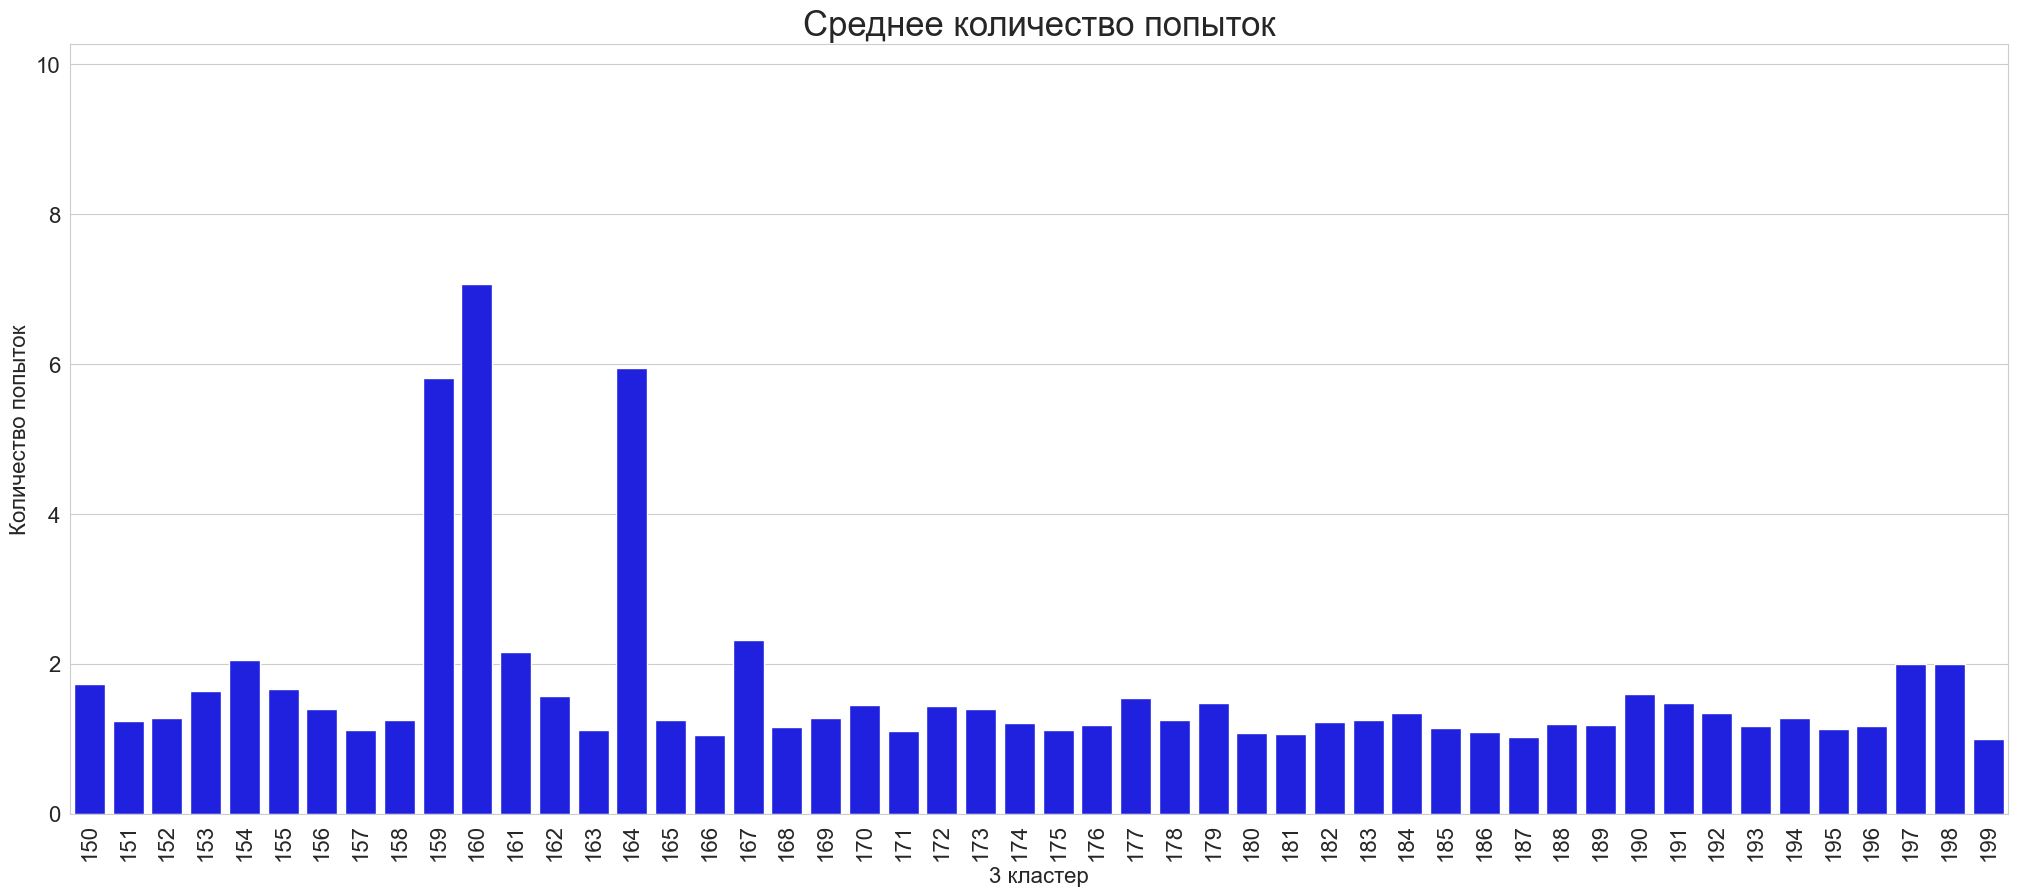

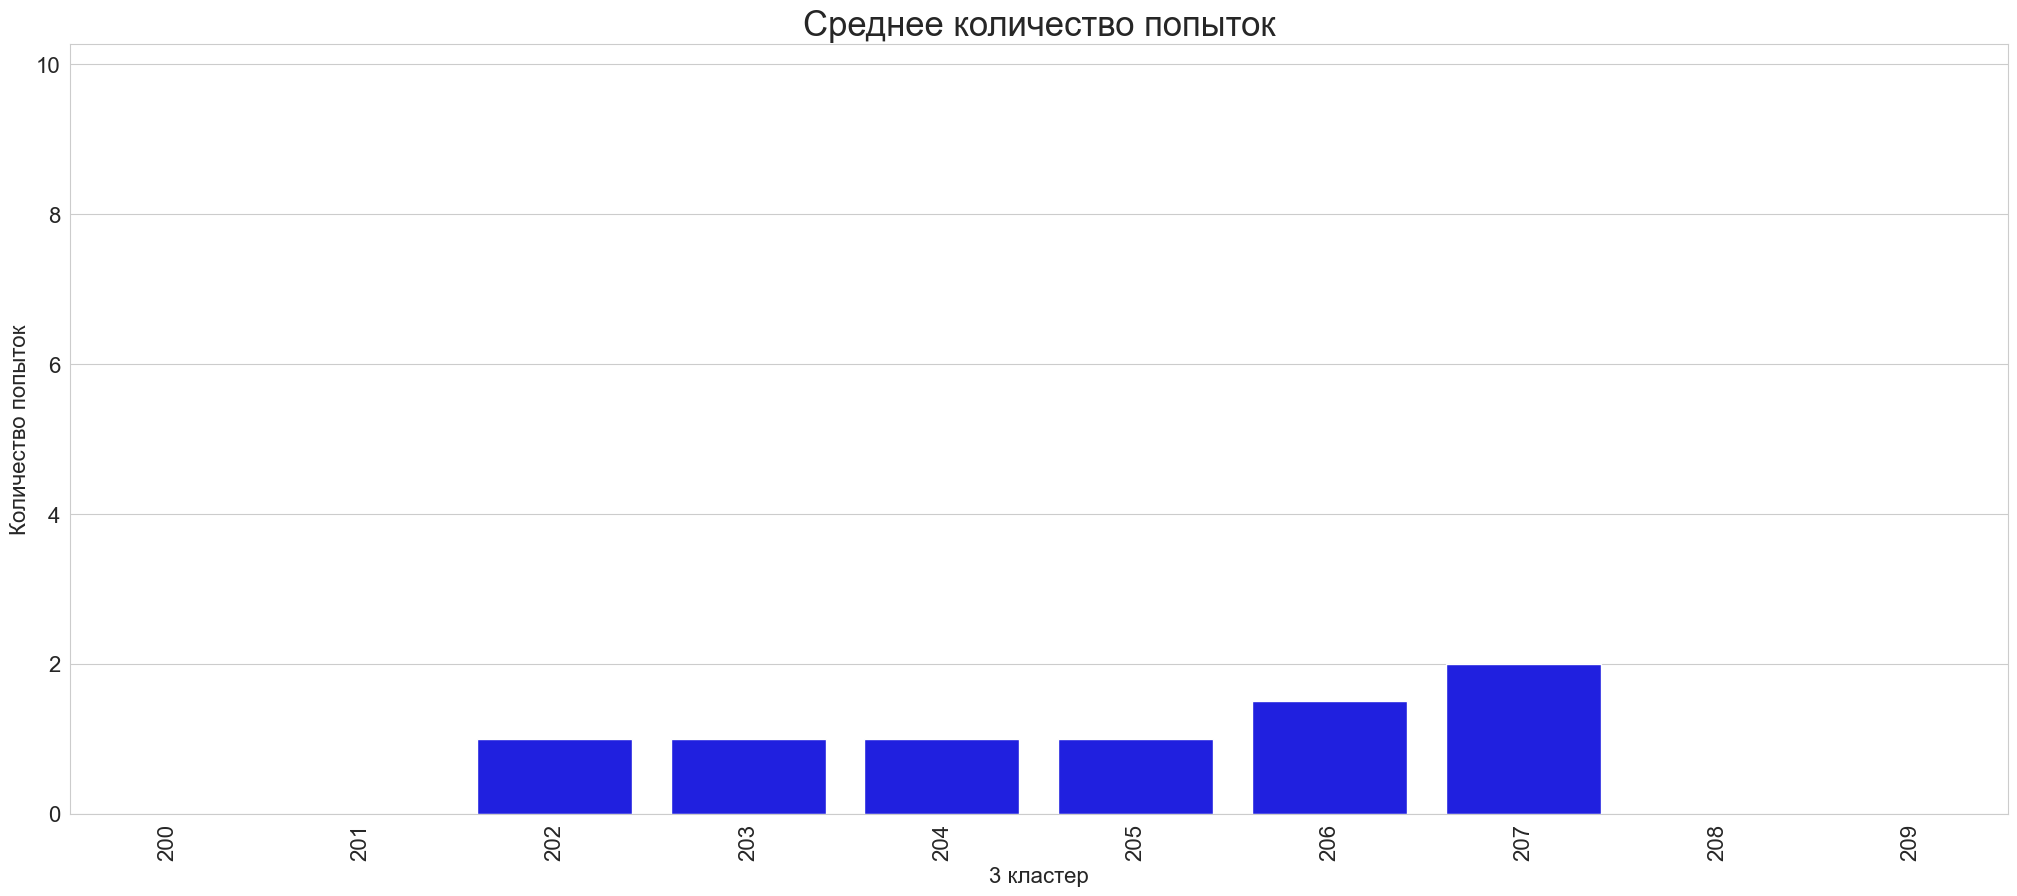

<Figure size 2000x1000 with 0 Axes>

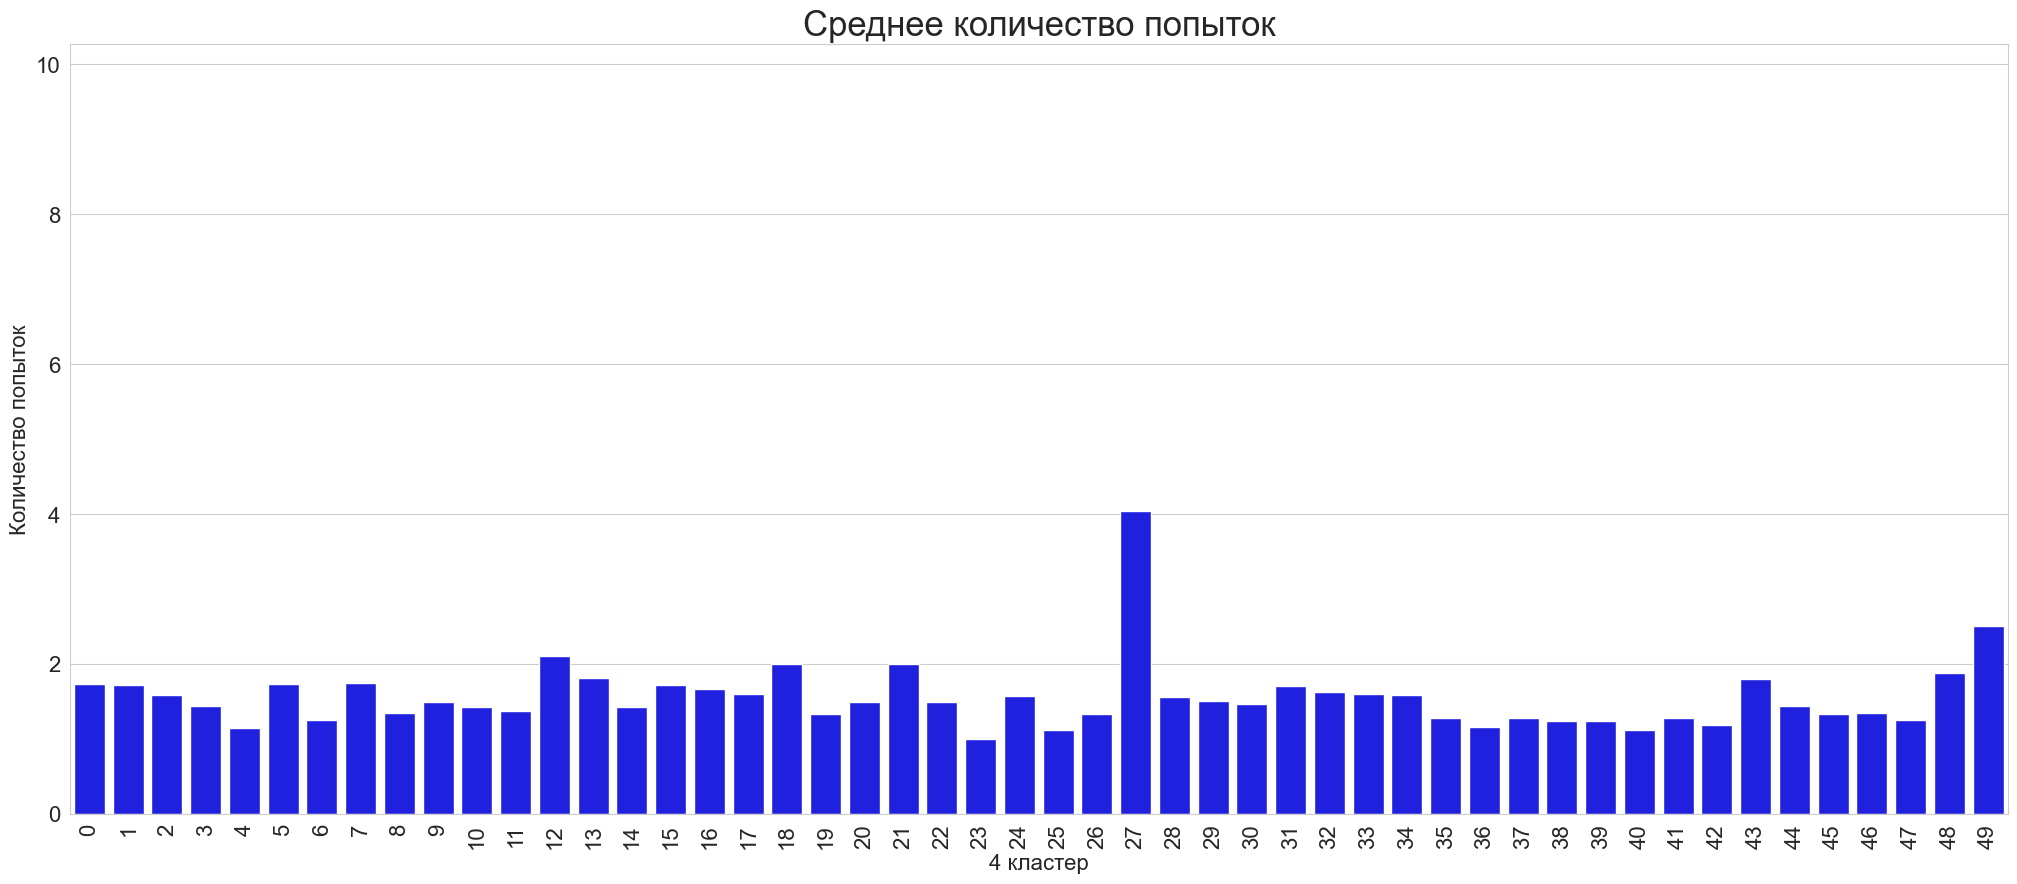

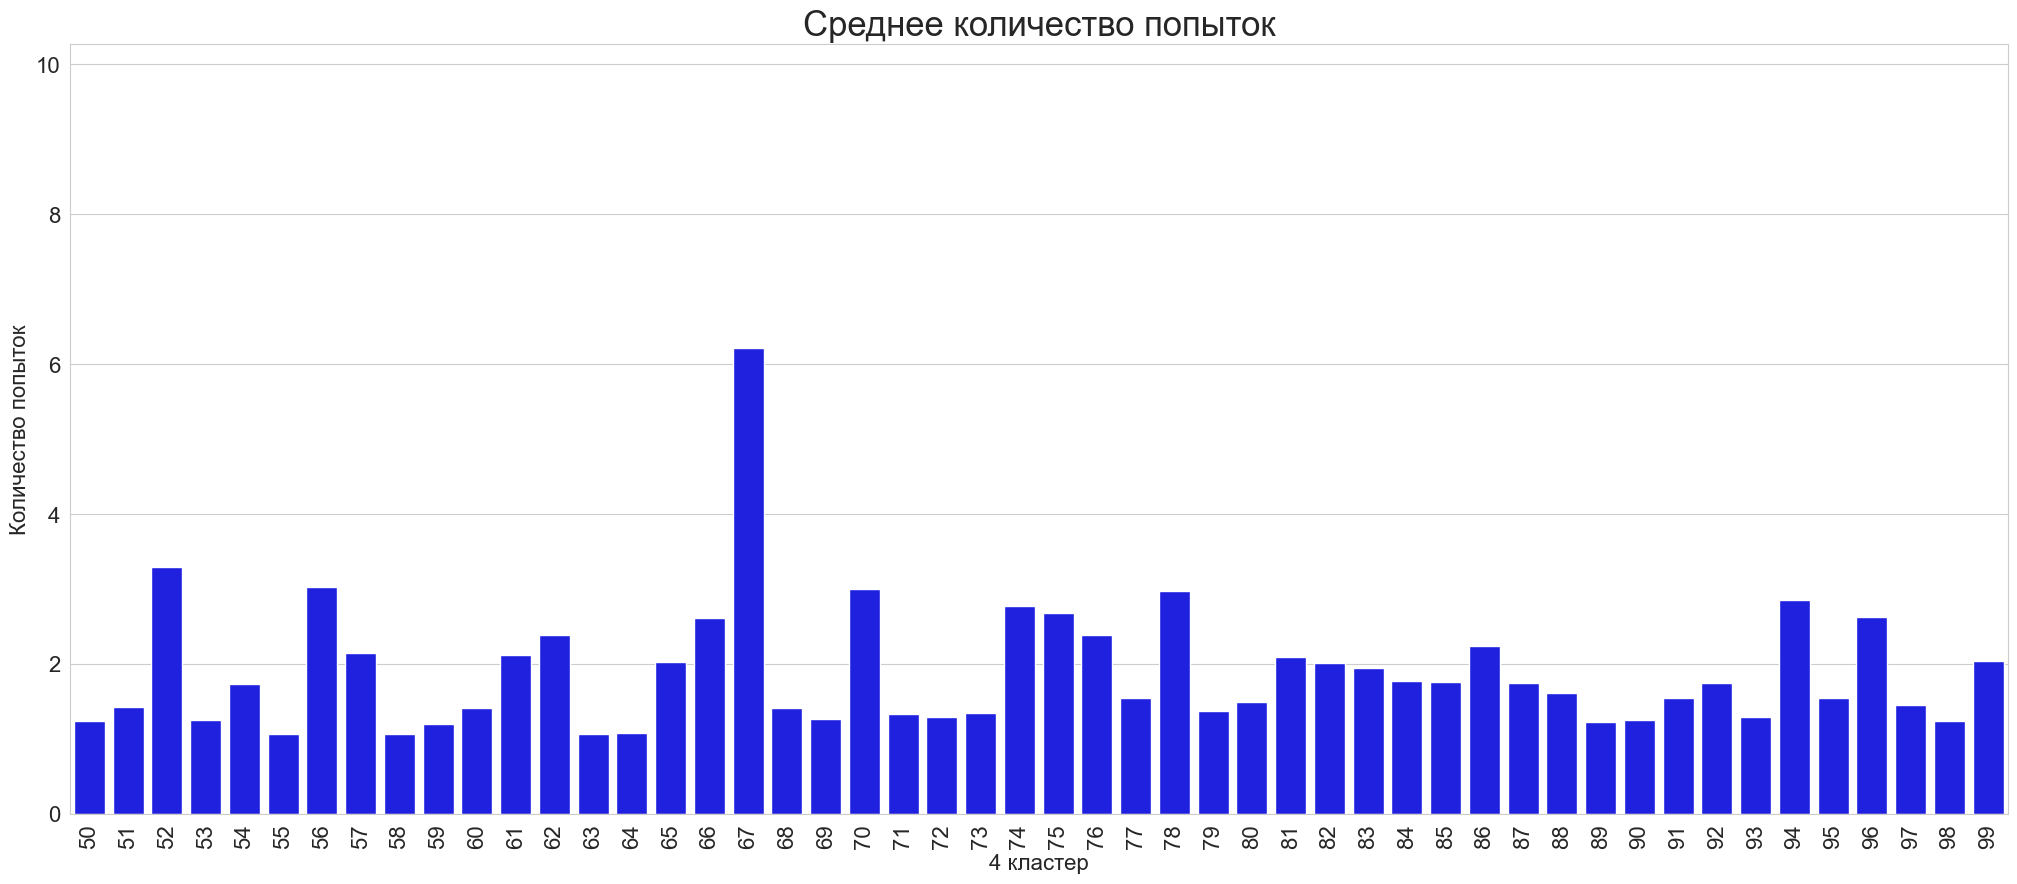

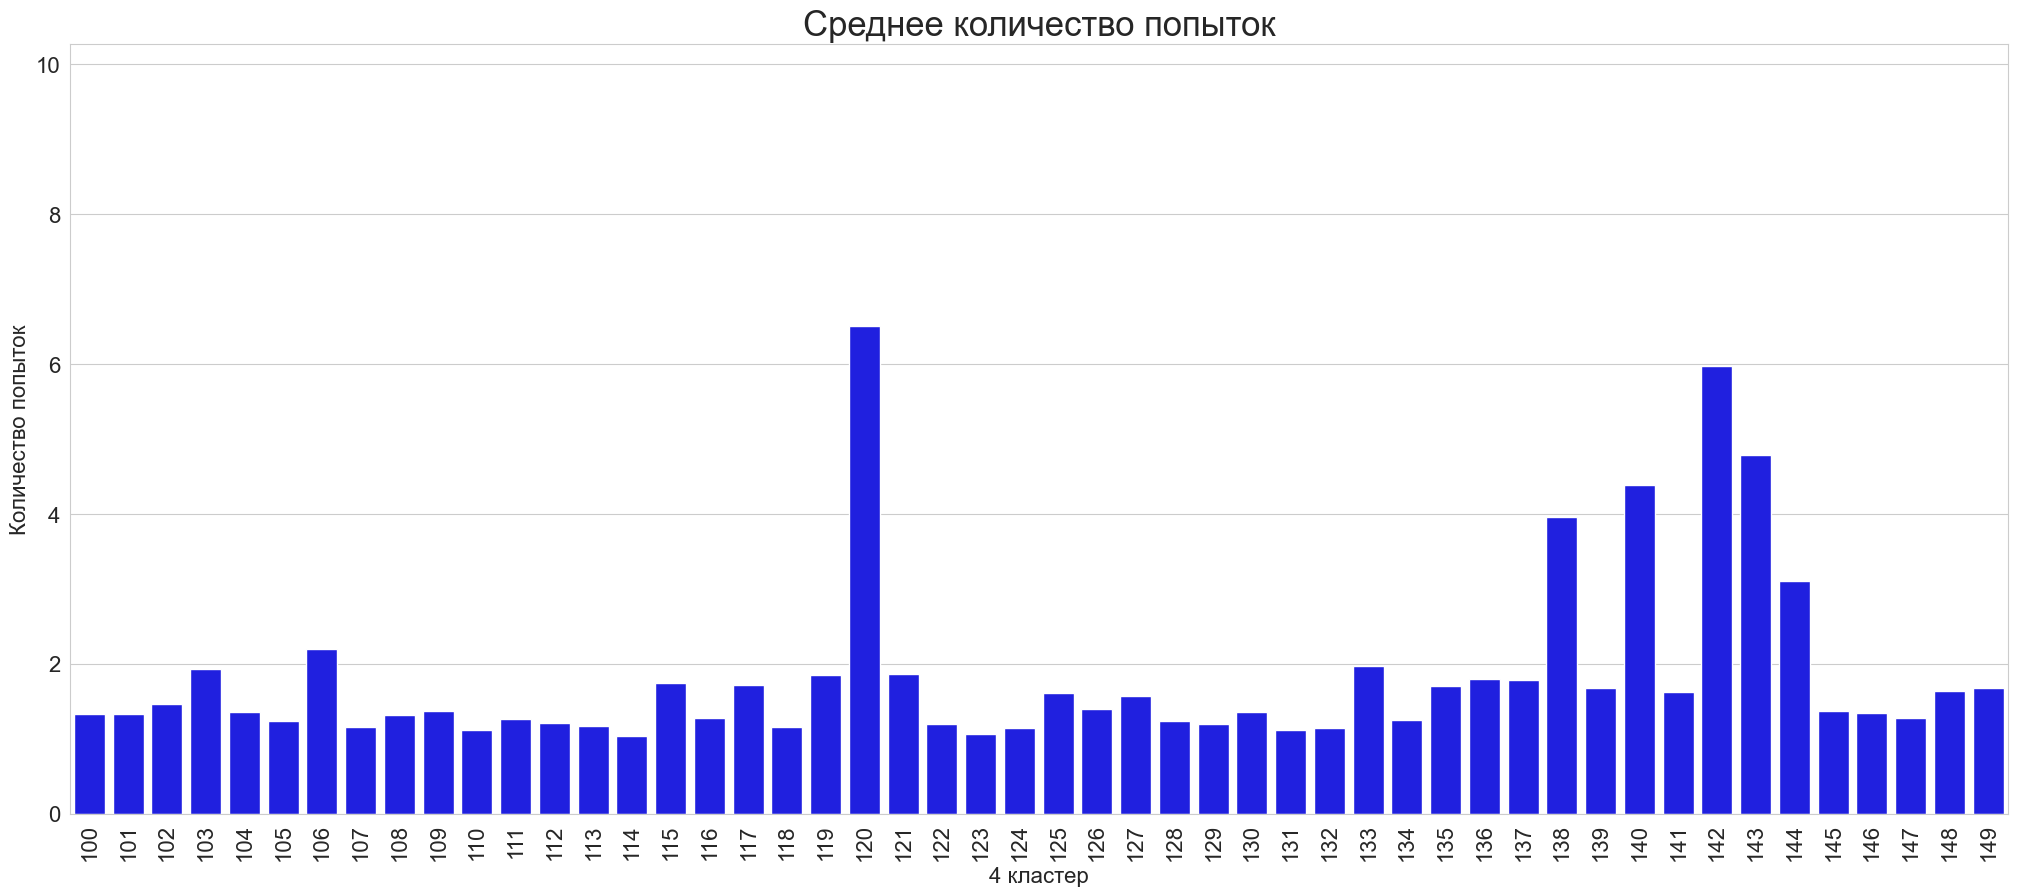

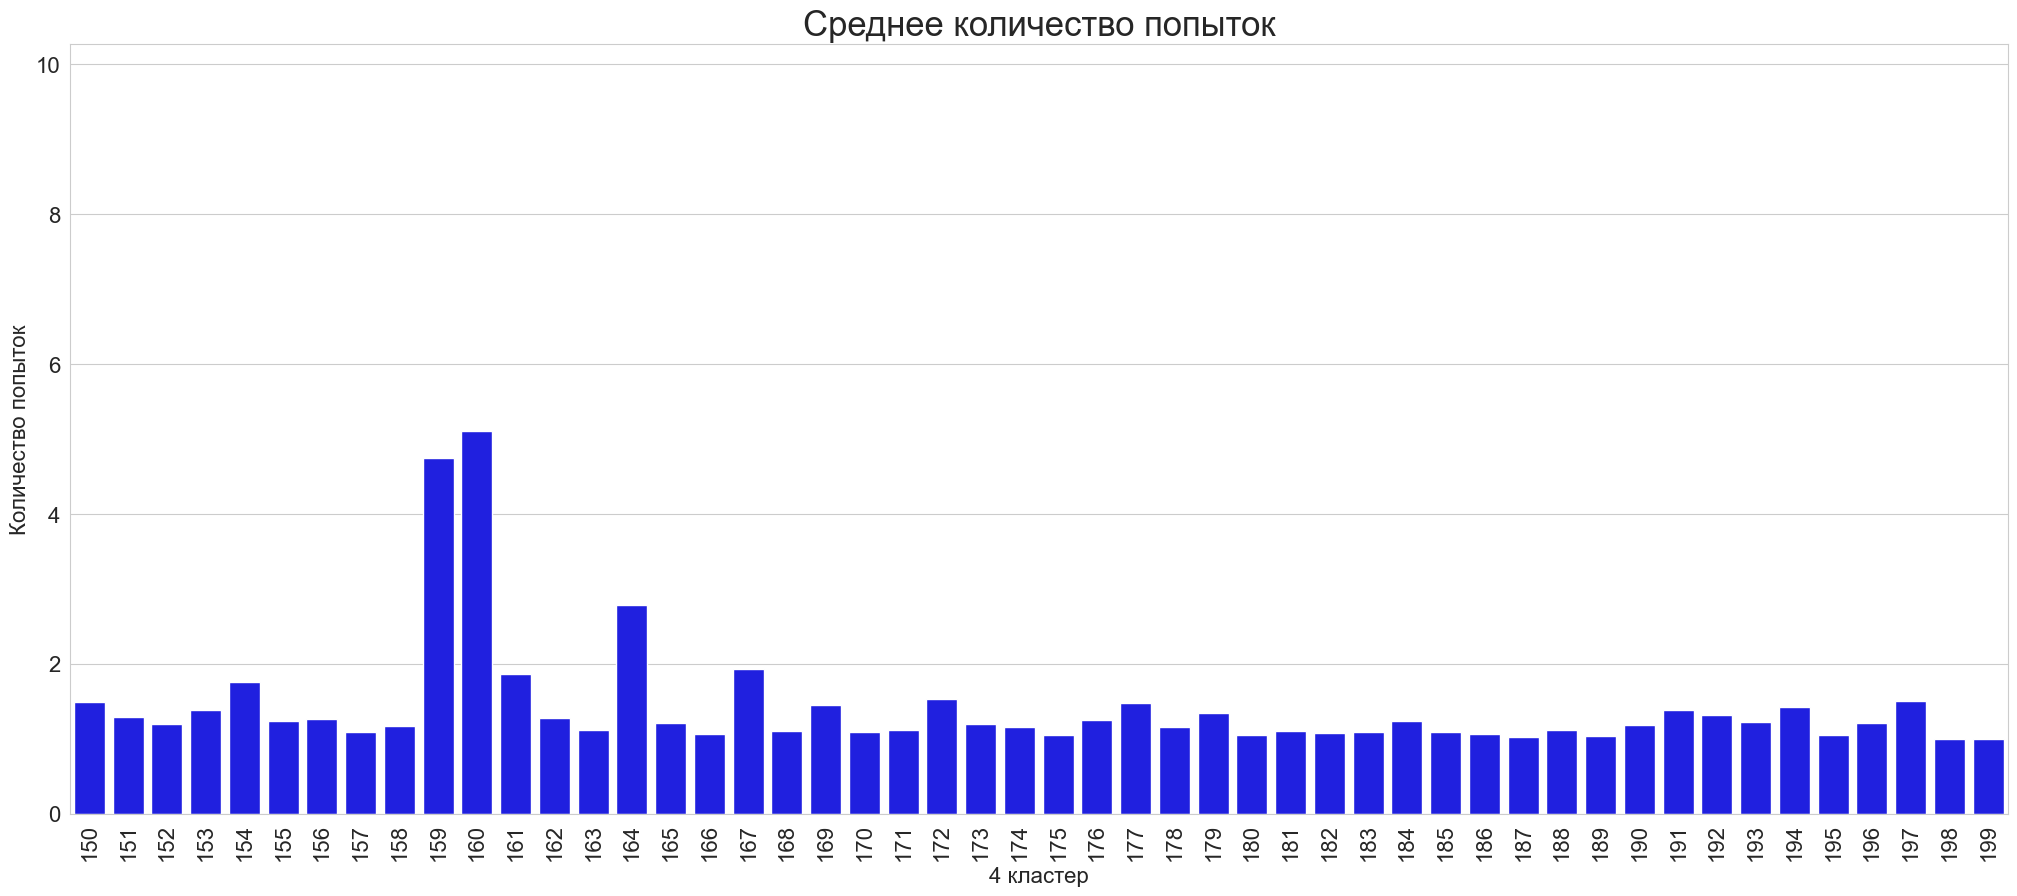

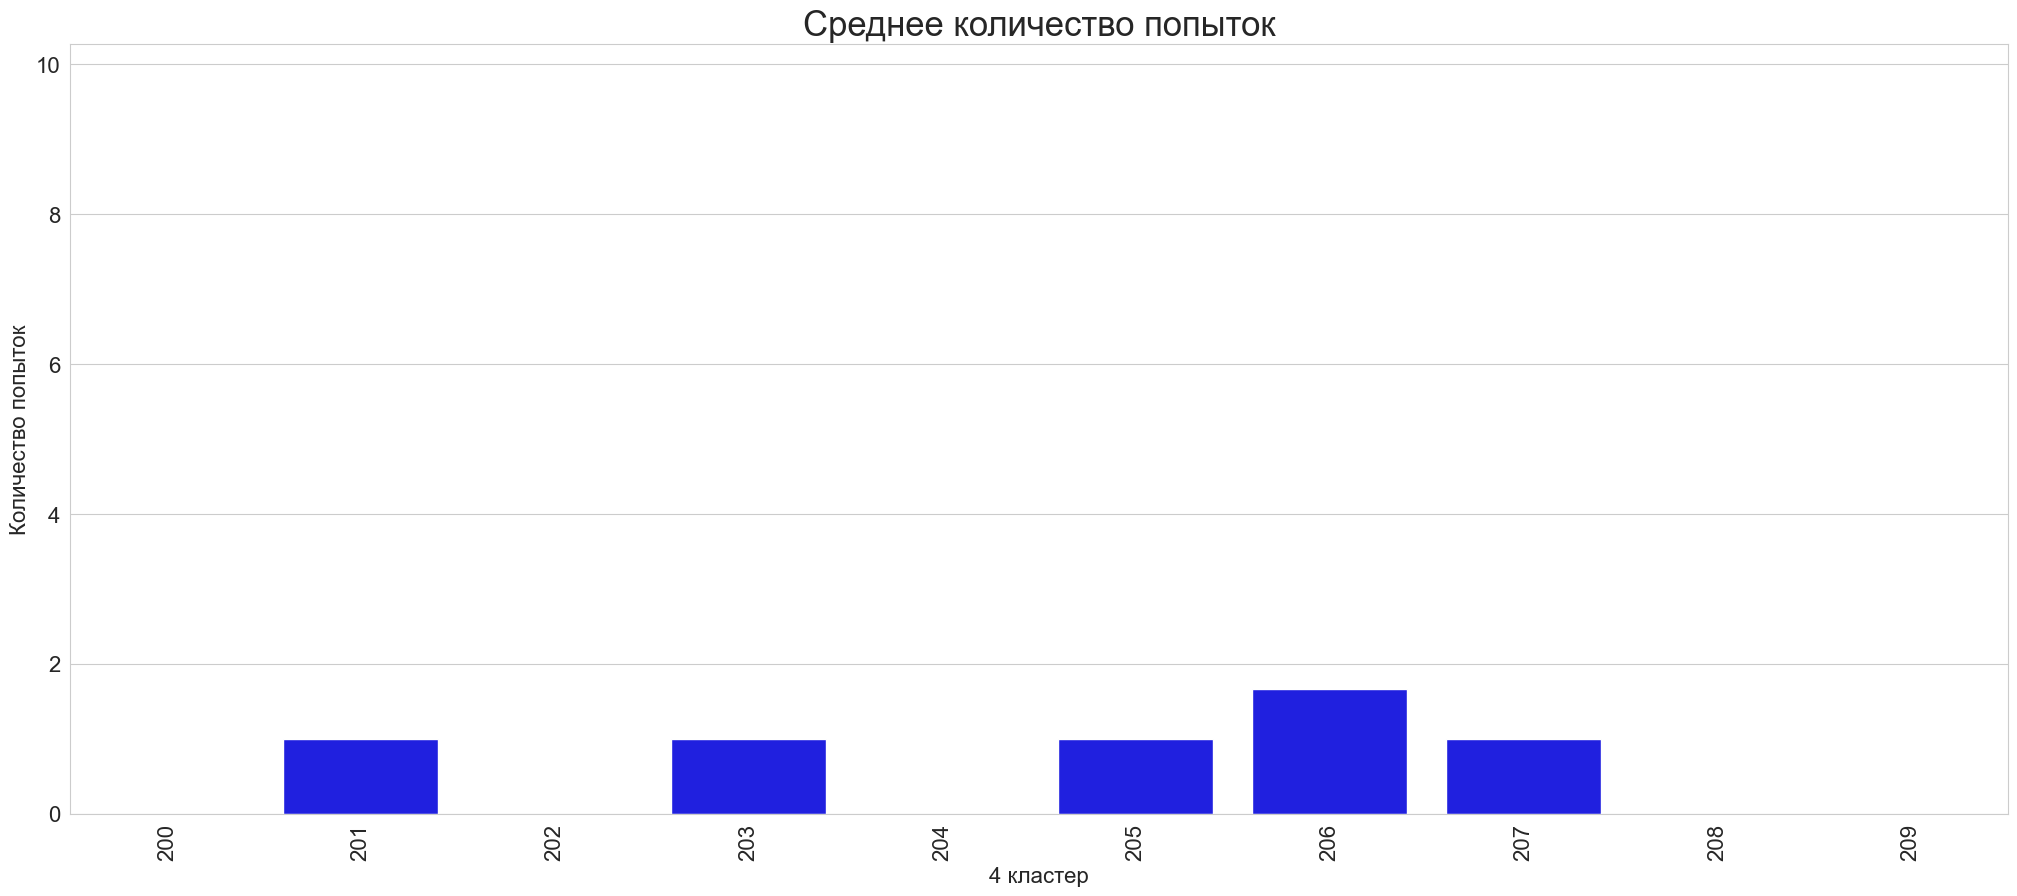

In [99]:
df_temp = df_all[['problem_id', 'cluster']].copy()
df_temp = df_temp.replace(0, np.NaN)
df_temp.columns = df_temp[['problem_id', 'cluster']].columns.droplevel()
df_temp.rename(columns={'': 'cluster'}, inplace=True)
df_mean_T = df_temp.groupby('cluster').mean().T
df_mean_T.index = df_mean_T.index.astype(int)
y_max = df_mean_T.max().max()
for i in df_mean_T.columns:
    ax = plt.figure(figsize=(20, 10))
    for j in range(0, math.ceil(df_mean_T.shape[0] / 50)):
        ax = plt.figure(figsize=(25, 10))
        sns.barplot(data=df_mean_T.loc[
            ((df_mean_T.index >= (j * 50)) & (df_mean_T.index < (j + 1) * 50)), i].reset_index(),
                    x='index', y=i, color='blue')
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.xlabel(str(i) + ' кластер', fontsize=16)
        plt.xticks(rotation=90)
        plt.ylim(0, y_max + 1)
        plt.title('Среднее количество попыток', fontsize=25)
        plt.ylabel('Количество попыток', fontsize=16)
        plt.show()

Среднее количество обращений к материалам

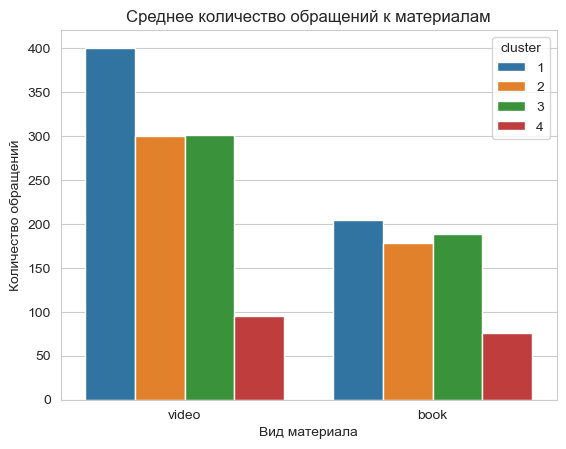

In [100]:
df_temp = df_all[['others', 'cluster']].copy()
df_temp.columns = df_all[['others', 'cluster']].columns.droplevel()
df_temp.rename(columns={'': 'cluster'}, inplace=True)
df_mean = df_temp.groupby('cluster').mean()
df_mean.columns = ['video', 'book', 'percent']
df_mean = df_mean.iloc[:, :-1].stack()
df_mean.name = 'values'
df_mean = df_mean.reset_index()
df_mean.columns = ['cluster', 'materials', 'values']
sns.barplot(data=df_mean, x='materials', y='values', hue='cluster')
plt.title('Среднее количество обращений к материалам')
plt.xlabel('Вид материала')
plt.ylabel('Количество обращений')
plt.show()

Процент выполнения заданий

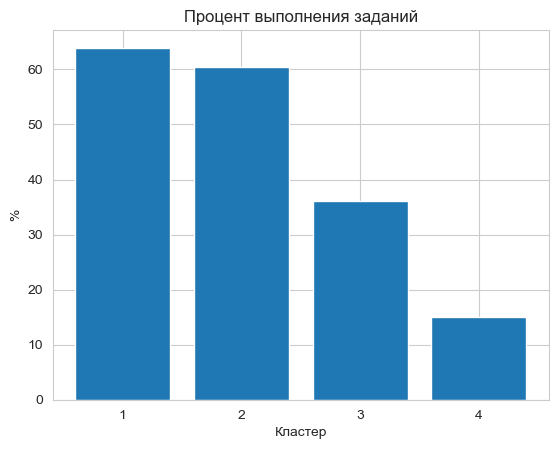

In [101]:
df_temp = df_all[['others', 'cluster']].copy()
df_temp.columns = df_all[['others', 'cluster']].columns.droplevel()
df_temp.rename(columns={'': 'cluster'}, inplace=True)
df_mean = df_temp.groupby('cluster').mean()
df_mean.columns = ['video', 'book', 'percent']
plt.bar((df_mean.index.values).astype(str), df_mean['percent'])
plt.title('Процент выполнения заданий')
plt.xlabel('Кластер')
plt.ylabel('%')
plt.show()